In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os  
from matplotlib.ticker import PercentFormatter
from scipy.optimize import curve_fit


# plot cpu, gpu power pattern for GPGPU apps
def replace_negative_with_average(data, column_name):
    for i in range(1, len(data) - 1):
        if data.at[i, column_name] < 0:
            previous_value = data.at[i - 1, column_name]
            next_value = data.at[i + 1, column_name]
            data.at[i, column_name] = (previous_value + next_value) / 2

def plot_power_CPU_GPU(cpu_filename, gpu_filename, benchmark):
    # Load the CSV files into DataFrames
    cpu_data = pd.read_csv(cpu_filename)
    gpu_data = pd.read_csv(gpu_filename)

    # Replace negative values with the average of the previous and next values
    replace_negative_with_average(cpu_data, 'Package Power (W)')
    replace_negative_with_average(gpu_data, 'GPU 0 Power (W)')

    # Plot the data
    plt.figure(figsize=(4, 3))
    plt.plot(cpu_data['Time (s)'], cpu_data['Package Power (W)'], label='RAPL Package Power', color='blue')
    plt.plot(gpu_data['Time (s)'], gpu_data['GPU 0 Power (W)'], label='GPU Power', color='red')
    plt.xlabel('Time (s)')
    plt.ylabel('Power (W)')
    plt.title(f'Power Consumption ({benchmark})', pad=40)
    # Position the legend outside the plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
    plt.grid(True, axis="y", alpha=0.5)
    
    # Make sure the ./fig directory exists, if not, create it
    # os.makedirs('./fig', exist_ok=True)
    # # Save the figure
    # plt.savefig(f'./fig/power_cpu_gpu_{benchmark}.jpg', bbox_inches='tight')
    plt.show()

def plot_power_CPU(cpu_filename, benchmark):
    # Load the CSV file into a DataFrame
    cpu_data = pd.read_csv(cpu_filename)

    # Filter the data to plot every 1 second (assuming data points every 0.1 seconds)
    filtered_cpu_data = cpu_data.iloc[::1]  # Select every 10th row

    # Plot the data
    plt.figure(figsize=(6, 4))
    plt.plot(filtered_cpu_data['Time (s)'], filtered_cpu_data['Package Power (W)'],
             label='RAPL Package Power', color='blue')
    plt.xlabel('Time (s)')
    plt.ylabel('Power (W)')
    plt.title(f'Power Consumption ({benchmark})', pad=40)
    
    # Position the legend outside the plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
    plt.grid(True, axis="y", alpha=0.5)
    
    # Save the figure in the ./fig directory
    # os.makedirs('./fig', exist_ok=True)
    # plt.savefig(f'./fig/power_cpu_{benchmark}.jpg', bbox_inches='tight')
    
    # Display the plot
    plt.show()




# plot the power capping results for GPGPU apps
def plot_power_cap(file_cpu_cap, file_gpu_cap, benchmark,altis):
    def calculate_modified_average(runtimes):
        """Calculate the average runtime after dropping the min and max values."""
        if len(runtimes) > 2:
            return (sum(runtimes) - min(runtimes) - max(runtimes)) / (len(runtimes) - 2)
        return sum(runtimes) / len(runtimes)  # Return average if we can't drop values

    def preprocess_dataframe(file_path):
        """Read and preprocess the data from a CSV file."""
        df = pd.read_csv(file_path)
        # Group by 'CPU Cap (W)' and 'GPU Cap (W)' and aggregate 'Runtime (s)'
        agg_df = df.groupby(['CPU Cap (W)', 'GPU Cap (W)'])['Runtime (s)'].apply(list).reset_index()
        agg_df['Runtime (s)'] = agg_df['Runtime (s)'].apply(calculate_modified_average)
        return agg_df
    
    # Set up subplot environment
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    # Process and plot CPU cap data
    df_cpu = preprocess_dataframe(file_cpu_cap)
    # Find base runtime for max CPU Cap
    base_runtime_cpu = df_cpu[df_cpu['CPU Cap (W)'] == df_cpu['CPU Cap (W)'].max()]['Runtime (s)'].iloc[0]
    df_cpu['Performance (%)'] = (base_runtime_cpu / df_cpu['Runtime (s)']) * 100

    # max cpu power cap is 125 for ALTIS, so 250-125 = 125 which is the "decrease start point"
    if altis:
        cap = 125
    else:
        cap = 0
        
    df_cpu['CPU Cap Decrease (W)'] = df_cpu['CPU Cap (W)'].max() + cap - df_cpu['CPU Cap (W)']  # Adjusted for ALTIS benchmark
    axs[0].plot(df_cpu['CPU Cap Decrease (W)'], df_cpu['Performance (%)'], 'o--', linewidth=5, markersize=10)
    axs[0].set_title(f'{benchmark}: fixed max GPU cap', fontsize=20)
    axs[0].set_xlabel('CPU Cap Decrease (W)', fontsize=20)
    axs[0].set_ylabel('Application Performance (%)', fontsize=20)

    # Process and plot GPU cap data
    df_gpu = preprocess_dataframe(file_gpu_cap)
    # Find base runtime for max GPU Cap
    base_runtime_gpu = df_gpu[df_gpu['GPU Cap (W)'] == df_gpu['GPU Cap (W)'].max()]['Runtime (s)'].iloc[0]
    df_gpu['Performance (%)'] = (base_runtime_gpu / df_gpu['Runtime (s)']) * 100
    df_gpu['GPU Cap Decrease (W)'] = df_gpu['GPU Cap (W)'].max() - df_gpu['GPU Cap (W)']
    axs[1].plot(df_gpu['GPU Cap Decrease (W)'], df_gpu['Performance (%)'], 'D--', color='r', linewidth=5, markersize=10)
    axs[1].set_title(f'{benchmark}: fixed max CPU cap', fontsize=20)
    axs[1].set_xlabel('GPU Cap Decrease (W)', fontsize=20)
    axs[1].set_ylabel('Application Performance (%)', fontsize=20)

    for ax in axs:
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()






def calculate_energy(cpu_file, gpu_file):


    # Load GPU data from CSV file
    gpu_data = pd.read_csv(gpu_file)
    # Clean negative values in GPU power data
    gpu_data = clean_data(gpu_data, 'GPU 0 Power (W)')
    
    # Extract the time and power columns for the GPU
    time_gpu = gpu_data['Time (s)'].values
    power_gpu = gpu_data['GPU 0 Power (W)'].values

    # Calculate the total GPU energy using the trapezoidal rule
    
    energy_gpu = 0.0
    for i in range(1, len(time_gpu)):
        dt = time_gpu[i] - time_gpu[i - 1]
        avg_power = (power_gpu[i] + power_gpu[i - 1]) / 2
        energy_gpu += avg_power * dt

    # Load CPU data from CSV file
    cpu_data = pd.read_csv(cpu_file)
    # Clean negative values in CPU power data
    cpu_data = clean_data(cpu_data, 'Package Power (W)')
    
    # Extract the time and power columns for the CPU
    time_cpu = cpu_data['Time (s)'].values
    power_cpu = cpu_data['Package Power (W)'].values

    # Calculate the total CPU energy using the trapezoidal rule
    energy_cpu = 0.0
    for i in range(1, len(time_cpu)):
        dt = time_cpu[i] - time_cpu[i - 1]
        avg_power = (power_cpu[i] + power_cpu[i - 1]) / 2
        energy_cpu += avg_power * dt

    # Sum the total energy consumption from both CPU and GPU
    total_energy = energy_cpu + energy_gpu
    return total_energy


def calculate_energy_cpu(cpu_file):


    # Load CPU data from CSV file
    cpu_data = pd.read_csv(cpu_file)
    # Clean negative values in CPU power data
    cpu_data = clean_data(cpu_data, 'Package Power (W)')
    
    # Extract the time and power columns for the CPU
    time_cpu = cpu_data['Time (s)'].values
    power_cpu = cpu_data['Package Power (W)'].values

    # Calculate the total CPU energy using the trapezoidal rule
    energy_cpu = 0.0
    for i in range(1, len(time_cpu)):
        dt = time_cpu[i] - time_cpu[i - 1]
        avg_power = (power_cpu[i] + power_cpu[i - 1]) / 2
        energy_cpu += avg_power * dt

    # Sum the total energy consumption from both CPU and GPU
    total_energy = energy_cpu 
    return total_energy


def clean_data(data, column):
    # Iterate through the data to find negative values
    for i in range(1, len(data) - 1):
        if data[column][i] < 0:
            # Replace with the average of the previous and next values
            data.loc[i, column] = (data.loc[i-1, column] + data.loc[i+1, column]) / 2
    return data


def plot_uncore_freq(uncore_file):
    file_path = uncore_file  
    data = pd.read_csv(file_path)
    
    # Plot Core 0 and Core 1 Uncore Frequencies over Time
    plt.figure(figsize=(4, 3))
    
    # Plot Core 0 Uncore Frequency
    plt.plot(data['Time (s)'], data['Core 0 Uncore Frequency (GHz)'], label='Core 0 Uncore Frequency (GHz)')
    
    # Plot Core 1 Uncore Frequency
    plt.plot(data['Time (s)'], data['Core 1 Uncore Frequency (GHz)'], label='Core 1 Uncore Frequency (GHz)')
    
    # Adding labels and title
    plt.xlabel('Time (s)')
    plt.ylabel('Uncore Frequency (GHz)')
    plt.title('Uncore Frequency')
    plt.legend()
    
    # Show the plot
    plt.show()


def extract_runtime(gpu_file):
    gpu_data = pd.read_csv(gpu_file)
    runtime = gpu_data['Time (s)'].values[-1]
    return runtime

def calculate_average_power(cpu_file):
    data = pd.read_csv(cpu_file)
    data = data[data["Package Power (W)"] > 0]
    average_power = data["Package Power (W)"].mean()
    return average_power



def calculate_savings_percentage(benchmarks, baseline_dir, min_uncore_dir, dynamic_uncore_dir, ups_uncore_dir):
    
    # Data collection for runtime, energy, and EDP savings
    runtimes_savings = {"min": [], "dynamic": [], "UPS": []}
    power_savings = {"min": [], "dynamic": [], "UPS": []}
    energy_savings = {"min": [], "dynamic": [], "UPS": []}
    edp_savings = {"min": [], "dynamic": [], "UPS": []}
    
    
    # Iterate through benchmarks and calculate savings
    for benchmark in benchmarks:
        # CPU and GPU files
        baseline_cpu_file = os.path.join(baseline_dir, f"{benchmark}_power_cpu.csv")
        min_cpu_file = os.path.join(min_uncore_dir, f"{benchmark}_power_cpu.csv")
        dynamic_cpu_file = os.path.join(dynamic_uncore_dir, f"{benchmark}_power_cpu.csv")
        ups_cpu_file = os.path.join(ups_uncore_dir, f"{benchmark}_power_cpu_ups.csv")

        
        baseline_gpu_file = os.path.join(baseline_dir, f"{benchmark}_power_gpu.csv")
        min_gpu_file = os.path.join(min_uncore_dir, f"{benchmark}_power_gpu.csv")
        dynamic_gpu_file = os.path.join(dynamic_uncore_dir, f"{benchmark}_power_gpu.csv")
        ups_gpu_file = os.path.join(ups_uncore_dir, f"{benchmark}_power_gpu_ups.csv")
    
        # Collect runtimes
        baseline_runtime = extract_runtime(baseline_gpu_file)
        min_runtime = extract_runtime(min_gpu_file)
        dynamic_runtime = extract_runtime(dynamic_gpu_file)
        ups_runtime = extract_runtime(ups_gpu_file)
        
        # Calculate runtime savings
        min_runtime_savings = ((baseline_runtime - min_runtime) / baseline_runtime) * 100
        dynamic_runtime_savings = ((baseline_runtime - dynamic_runtime) / baseline_runtime) * 100
        ups_runtime_savings = ((baseline_runtime - ups_runtime) / baseline_runtime) * 100
        
        runtimes_savings["min"].append(min_runtime_savings)
        runtimes_savings["dynamic"].append(dynamic_runtime_savings)
        runtimes_savings["UPS"].append(ups_runtime_savings)



        # Calculate power savings
        baseline_power = calculate_average_power(baseline_cpu_file)
        min_power = calculate_average_power(min_cpu_file)
        dynamic_power = calculate_average_power(dynamic_cpu_file)
        ups_power = calculate_average_power(ups_cpu_file)

        min_power_savings = ((baseline_power - min_power) / baseline_power) * 100
        dynamic_power_savings = ((baseline_power - dynamic_power) / baseline_power) * 100
        ups_power_savings = ((baseline_power - ups_power) / baseline_power) * 100

        power_savings["min"].append(min_power_savings)
        power_savings["dynamic"].append(dynamic_power_savings)
        power_savings["UPS"].append(ups_power_savings)
        
        # Collect energy consumptions
        baseline_energy = calculate_energy(baseline_cpu_file, baseline_gpu_file)
        min_energy = calculate_energy(min_cpu_file, min_gpu_file)
        dynamic_energy = calculate_energy(dynamic_cpu_file, dynamic_gpu_file)
        ups_energy = calculate_energy(ups_cpu_file, ups_gpu_file)

        
        # Calculate energy savings
        min_energy_savings = ((baseline_energy - min_energy) / baseline_energy) * 100
        dynamic_energy_savings = ((baseline_energy - dynamic_energy) / baseline_energy) * 100
        ups_energy_savings = ((baseline_energy - ups_energy) / baseline_energy) * 100
        
        energy_savings["min"].append(min_energy_savings)
        energy_savings["dynamic"].append(dynamic_energy_savings)
        energy_savings["UPS"].append(ups_energy_savings)
    
        # Calculate EDP (Energy Delay Product)
        baseline_edp = baseline_runtime * baseline_runtime * baseline_energy
        min_edp = min_runtime * min_runtime * min_energy
        dynamic_edp = dynamic_runtime * dynamic_runtime * dynamic_energy
        ups_edp = ups_runtime * ups_runtime * ups_energy
    
        min_edp_savings = ((baseline_edp - min_edp) / baseline_edp) * 100
        dynamic_edp_savings = ((baseline_edp - dynamic_edp) / baseline_edp) * 100
        ups_edp_savings = ((baseline_edp - ups_edp) / baseline_edp) * 100
    
        edp_savings["min"].append(min_edp_savings)
        edp_savings["dynamic"].append(dynamic_edp_savings)
        edp_savings["UPS"].append(ups_edp_savings)

    

    return runtimes_savings, energy_savings, edp_savings, power_savings

def calculate_savings_percentage_cpu(benchmarks, baseline_dir, min_uncore_dir, dynamic_uncore_dir, ups_uncore_dir):
    
    # Data collection for runtime, energy, and EDP savings
    runtimes_savings = {"min": [], "dynamic": [], "UPS": []}
    power_savings = {"min": [], "dynamic": [], "UPS": []}
    energy_savings = {"min": [], "dynamic": [], "UPS": []}
    edp_savings = {"min": [], "dynamic": [], "UPS": []}
    
    
    # Iterate through benchmarks and calculate savings
    for benchmark in benchmarks:
        # CPU and GPU files
        baseline_cpu_file = os.path.join(baseline_dir, f"{benchmark}_power_cpu.csv")
        min_cpu_file = os.path.join(min_uncore_dir, f"{benchmark}_power_cpu.csv")
        dynamic_cpu_file = os.path.join(dynamic_uncore_dir, f"{benchmark}_power_cpu.csv")
        ups_cpu_file = os.path.join(ups_uncore_dir, f"{benchmark}_power_cpu_ups.csv")

       
    
        # Collect runtimes
        baseline_runtime = extract_runtime(baseline_cpu_file)
        min_runtime = extract_runtime(min_cpu_file)
        dynamic_runtime = extract_runtime(dynamic_cpu_file)
        ups_runtime = extract_runtime(ups_cpu_file)
        
        # Calculate runtime savings
        min_runtime_savings = ((baseline_runtime - min_runtime) / baseline_runtime) * 100
        dynamic_runtime_savings = ((baseline_runtime - dynamic_runtime) / baseline_runtime) * 100
        ups_runtime_savings = ((baseline_runtime - ups_runtime) / baseline_runtime) * 100
        
        runtimes_savings["min"].append(min_runtime_savings)
        runtimes_savings["dynamic"].append(dynamic_runtime_savings)
        runtimes_savings["UPS"].append(ups_runtime_savings)



        # Calculate power savings
        baseline_power = calculate_average_power(baseline_cpu_file)
        min_power = calculate_average_power(min_cpu_file)
        dynamic_power = calculate_average_power(dynamic_cpu_file)
        ups_power = calculate_average_power(ups_cpu_file)

        min_power_savings = ((baseline_power - min_power) / baseline_power) * 100
        dynamic_power_savings = ((baseline_power - dynamic_power) / baseline_power) * 100
        ups_power_savings = ((baseline_power - ups_power) / baseline_power) * 100

        power_savings["min"].append(min_power_savings)
        power_savings["dynamic"].append(dynamic_power_savings)
        power_savings["UPS"].append(ups_power_savings)
        
        # Collect energy consumptions
    
        baseline_energy = calculate_energy_cpu(baseline_cpu_file)
        min_energy = calculate_energy_cpu(min_cpu_file)
        dynamic_energy = calculate_energy_cpu(dynamic_cpu_file)
        ups_energy = calculate_energy_cpu(ups_cpu_file)
        
        # Calculate energy savings
        min_energy_savings = ((baseline_energy - min_energy) / baseline_energy) * 100
        dynamic_energy_savings = ((baseline_energy - dynamic_energy) / baseline_energy) * 100
        ups_energy_savings = ((baseline_energy - ups_energy) / baseline_energy) * 100
        
        energy_savings["min"].append(min_energy_savings)
        energy_savings["dynamic"].append(dynamic_energy_savings)
        energy_savings["UPS"].append(ups_energy_savings)
    
        # Calculate EDP (Energy Delay Product)
        baseline_edp = baseline_runtime * baseline_runtime * baseline_energy
        min_edp = min_runtime * min_runtime * min_energy
        dynamic_edp = dynamic_runtime * dynamic_runtime * dynamic_energy
        ups_edp = ups_runtime * ups_runtime * ups_energy
    
        min_edp_savings = ((baseline_edp - min_edp) / baseline_edp) * 100
        dynamic_edp_savings = ((baseline_edp - dynamic_edp) / baseline_edp) * 100
        ups_edp_savings = ((baseline_edp - ups_edp) / baseline_edp) * 100
    
        edp_savings["min"].append(min_edp_savings)
        edp_savings["dynamic"].append(dynamic_edp_savings)
        edp_savings["UPS"].append(ups_edp_savings)

    

    return runtimes_savings, energy_savings, edp_savings, power_savings


def calculate_savings_num(benchmarks, baseline_dir, min_uncore_dir, dynamic_uncore_dir, ups_uncore_dir):
    
    # Data collection for runtime and energy savings
    runtimes_savings = {"min": [], "dynamic": [], "UPS": []}
    energy_savings = {"min": [], "dynamic": [], "UPS": []}
    
    # Iterate through benchmarks and calculate savings
    for benchmark in benchmarks:
        # CPU and GPU files
        baseline_cpu_file = os.path.join(baseline_dir, f"{benchmark}_power_cpu.csv")
        baseline_gpu_file = os.path.join(baseline_dir, f"{benchmark}_power_gpu.csv")
        
        min_cpu_file = os.path.join(min_uncore_dir, f"{benchmark}_power_cpu.csv")
        min_gpu_file = os.path.join(min_uncore_dir, f"{benchmark}_power_gpu.csv")
        
        dynamic_cpu_file = os.path.join(dynamic_uncore_dir, f"{benchmark}_power_cpu.csv")
        dynamic_gpu_file = os.path.join(dynamic_uncore_dir, f"{benchmark}_power_gpu.csv")
        
        ups_cpu_file = os.path.join(ups_uncore_dir, f"{benchmark}_power_cpu_ups.csv")
        ups_gpu_file = os.path.join(ups_uncore_dir, f"{benchmark}_power_gpu_ups.csv")
        
        # Collect runtimes
        baseline_runtime = extract_runtime(baseline_gpu_file)
        min_runtime = extract_runtime(min_gpu_file)
        dynamic_runtime = extract_runtime(dynamic_gpu_file)
        ups_runtime = extract_runtime(ups_gpu_file)
        
        # Calculate runtime savings
        min_runtime_savings = baseline_runtime - min_runtime
        dynamic_runtime_savings = baseline_runtime - dynamic_runtime
        ups_runtime_savings = baseline_runtime - ups_runtime
        
        runtimes_savings["min"].append(min_runtime_savings)
        runtimes_savings["dynamic"].append(dynamic_runtime_savings)
        runtimes_savings["UPS"].append(ups_runtime_savings)
        
        # Collect energy consumptions
        baseline_energy = calculate_energy(baseline_cpu_file, baseline_gpu_file)
        min_energy = calculate_energy(min_cpu_file, min_gpu_file)
        dynamic_energy = calculate_energy(dynamic_cpu_file, dynamic_gpu_file)
        ups_energy = calculate_energy(ups_cpu_file, ups_gpu_file)
        
        # Calculate energy savings
        min_energy_savings = baseline_energy - min_energy
        dynamic_energy_savings = baseline_energy - dynamic_energy
        ups_energy_savings = baseline_energy - ups_energy
        
        energy_savings["min"].append(min_energy_savings)
        energy_savings["dynamic"].append(dynamic_energy_savings)
        energy_savings["UPS"].append(ups_energy_savings)
    
    return runtimes_savings, energy_savings



# Plotting runtime and energy savings
def plot_combined_bars_savings(runtime_data, energy_data, edp_savings, power_savings, benchmarks, legend_labels, fig_name, ups=1):
    x = np.arange(len(benchmarks))  # Label locations
    width = 0.25  # Bar width for three groups

    fig, axes = plt.subplots(4, 1, figsize=(12, 20), sharex=True)
    ax1, ax2, ax3, ax4 = axes

    # Plot runtime savings
    bars_dynamic_runtime = ax1.bar(x, runtime_data["dynamic"], width, label=legend_labels[1])
    if ups == 1:
        bars_ups_runtime = ax1.bar(x + width, runtime_data["UPS"], width, label=legend_labels[2])
    ax1.set_ylabel('Runtime Savings (%)', fontsize=18)
    ax1.tick_params(axis='y', labelsize=15)
    ax1.legend(fontsize=12)

    # Plot power savings
    bars_dynamic_power = ax2.bar(x, power_savings["dynamic"], width, label=legend_labels[1])
    if ups == 1:
        bars_ups_power = ax2.bar(x + width, power_savings["UPS"], width, label=legend_labels[2])
    ax2.set_ylabel('Power Savings (%)', fontsize=18)
    ax2.tick_params(axis='y', labelsize=15)
    ax2.legend(fontsize=12)

    # Plot energy savings
    bars_dynamic_energy = ax3.bar(x, energy_data["dynamic"], width, label=legend_labels[1])
    if ups == 1:
        bars_ups_energy = ax3.bar(x + width, energy_data["UPS"], width, label=legend_labels[2])
    ax3.set_ylabel('Energy Savings (%)', fontsize=18)
    ax3.tick_params(axis='y', labelsize=15)
    ax3.legend(fontsize=12)

    # Plot ED²P savings
    bars_dynamic_edp = ax4.bar(x, edp_savings["dynamic"], width, label=legend_labels[1])
    if ups == 1:
        bars_ups_edp = ax4.bar(x + width, edp_savings["UPS"], width, label=legend_labels[2])
    ax4.set_xlabel('Benchmarks', fontsize=18)
    ax4.set_ylabel('ED²P Savings (%)', fontsize=18)
    ax4.tick_params(axis='x', labelsize=15)
    ax4.tick_params(axis='y', labelsize=15)
    ax4.set_xticks(x)
    ax4.set_xticklabels(benchmarks, rotation=90, fontsize=16)

    # Adjust layout
    fig.tight_layout(pad=3.0)
    os.makedirs('./fig', exist_ok=True)  # Create the directory if it doesn't exist
    save_path = os.path.join('./fig', f'{fig_name}.png')
    plt.savefig(save_path, format='png', dpi=300)

    plt.show()






def plot_memory_throughput(mem_tps_dir_max, mem_tps_dir_min, mem_tps_dir_dynamic, mem_tps_dir_ups, app):
    
    # Read the CSV files for max, min, and dynamic uncore frequency cases
    max_file = os.path.join(mem_tps_dir_max, f"{app}.csv")
    min_file = os.path.join(mem_tps_dir_min, f"{app}.csv")
    dynamic_file = os.path.join(mem_tps_dir_dynamic, f"{app}.csv")
    
    ups_file = os.path.join(mem_tps_dir_ups, f"{app}_ups.csv")
    
    # Read and clean data for each case
    data_max = pd.read_csv(max_file)
    data_max.columns = data_max.columns.str.strip()

    data_min = pd.read_csv(min_file)
    data_min.columns = data_min.columns.str.strip()

    data_dynamic = pd.read_csv(dynamic_file)
    data_dynamic.columns = data_dynamic.columns.str.strip()

    data_ups = pd.read_csv(ups_file)
    data_ups.columns = data_ups.columns.str.strip()
    
    # Convert time to seconds, assuming each row is spaced by 0.1 seconds
    max_length = max(len(data_max), len(data_min), len(data_dynamic))
    time_seconds = [1 + i * 0.1 for i in range(max_length)]
    
    # Pad the shorter datasets with NaN values
    data_max = data_max.reindex(range(max_length)).reset_index(drop=True)
    data_min = data_min.reindex(range(max_length)).reset_index(drop=True)
    data_dynamic = data_dynamic.reindex(range(max_length)).reset_index(drop=True)
    data_ups = data_ups.reindex(range(max_length)).reset_index(drop=True)

    # Create the plot
    plt.figure(figsize=(8, 4))

    # Plot data
    plt.plot(time_seconds, data_max['total(MB/s)'], label='Max Uncore Freq', linestyle='-')
    plt.plot(time_seconds, data_dynamic['total(MB/s)'], label='MAGUS', linestyle='-')
    # plt.plot(time_seconds, data_min['total(MB/s)'], label='Min Uncore Freq', linestyle='-')
    plt.plot(time_seconds, data_ups['total(MB/s)'], label='UPS', linestyle='-')

    # Add labels, title, and legend
    plt.xlabel('Time (seconds)', fontsize=16)
    plt.ylabel('Memory Throughput (MB/s)', fontsize=16)
    plt.title(f'{app}')
    plt.legend()

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Save the figure to the ./fig directory
    os.makedirs('./fig', exist_ok=True)  # Create the directory if it doesn't exist
    save_path = os.path.join('./fig', f'mem_tps_{app}.png')
    plt.tight_layout()
    plt.savefig(save_path, format='png', dpi=300)

    # Show the plot
    plt.show()


# ALTIS

## Power Pattern

### Dynamic Uncore

In [11]:
data_dir = "./altis_power_res/no_power_shift/dynamic_uncore/"

# altis_benchmarks_0
busspeeddownload_cpu = data_dir + "busspeeddownload_power_cpu.csv"
busspeeddownload_gpu = data_dir + "busspeeddownload_power_gpu.csv"

busspeedreadback_cpu = data_dir + "busspeedreadback_power_cpu.csv"
busspeedreadback_gpu = data_dir + "busspeedreadback_power_gpu.csv"

maxflops_cpu = data_dir + "maxflops_power_cpu.csv"
maxflops_gpu = data_dir + "maxflops_power_gpu.csv"

# altis_benchmarks_1
bfs_cpu = data_dir + "bfs_power_cpu.csv"
bfs_gpu = data_dir + "bfs_power_gpu.csv"

gemm_cpu = data_dir + "gemm_power_cpu.csv"
gemm_gpu = data_dir + "gemm_power_gpu.csv"

gups_cpu = data_dir + "gups_power_cpu.csv"
gups_gpu = data_dir + "gups_power_gpu.csv"

pathfinder_cpu = data_dir + "pathfinder_power_cpu.csv"
pathfinder_gpu = data_dir + "pathfinder_power_gpu.csv"

sort_cpu = data_dir + "sort_power_cpu.csv"
sort_gpu = data_dir + "sort_power_gpu.csv"

# altis_benchmarks_2
cfd_cpu = data_dir + "cfd_power_cpu.csv"
cfd_gpu = data_dir + "cfd_power_gpu.csv"

cfd_double_cpu = data_dir + "cfd_double_power_cpu.csv"
cfd_double_gpu = data_dir + "cfd_double_power_gpu.csv"


fdtd2d_cpu = data_dir + "fdtd2d_power_cpu.csv"
fdtd2d_gpu = data_dir + "fdtd2d_power_gpu.csv"

kmeans_cpu = data_dir + "kmeans_power_cpu.csv"
kmeans_gpu = data_dir + "kmeans_power_gpu.csv"

lavamd_cpu = data_dir + "lavamd_power_cpu.csv"
lavamd_gpu = data_dir + "lavamd_power_gpu.csv"

nw_cpu = data_dir + "nw_power_cpu.csv"
nw_gpu = data_dir + "nw_power_gpu.csv"

particlefilter_float_cpu = data_dir + "particlefilter_float_power_cpu.csv"
particlefilter_float_gpu = data_dir + "particlefilter_float_power_gpu.csv"

particlefilter_naive_cpu = data_dir + "particlefilter_naive_power_cpu.csv"
particlefilter_naive_gpu = data_dir + "particlefilter_naive_power_gpu.csv"

raytracing_cpu = data_dir + "raytracing_power_cpu.csv"
raytracing_gpu = data_dir + "raytracing_power_gpu.csv"

srad_cpu = data_dir + "srad_power_cpu.csv"
srad_gpu = data_dir + "srad_power_gpu.csv"

where_cpu = data_dir + "where_power_cpu.csv"
where_gpu = data_dir + "where_power_gpu.csv"

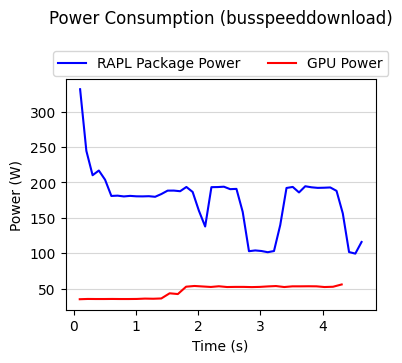

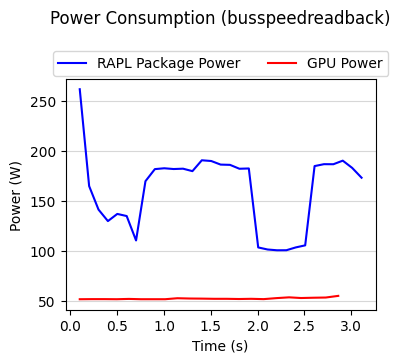

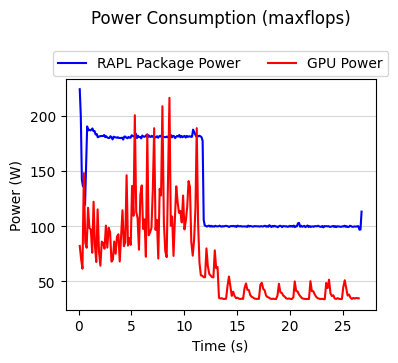

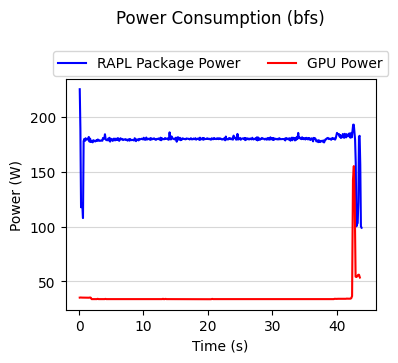

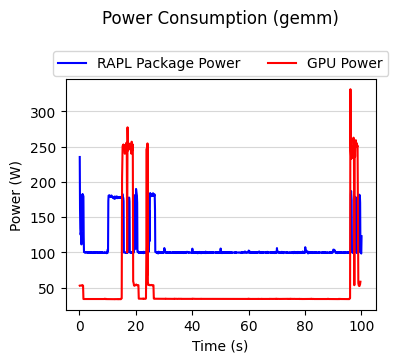

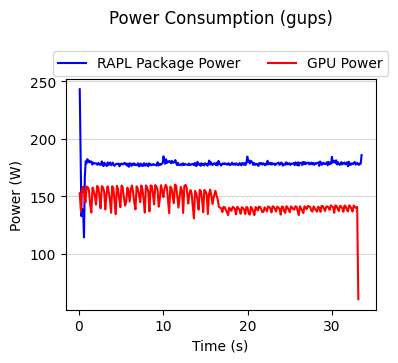

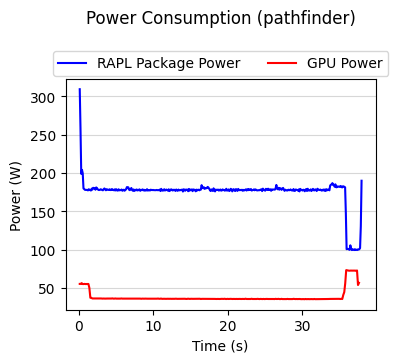

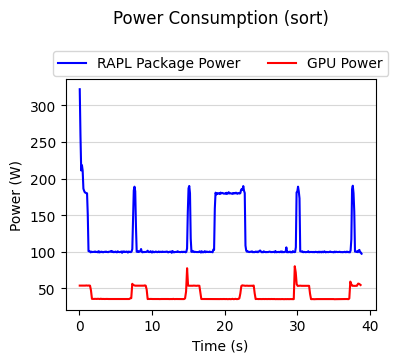

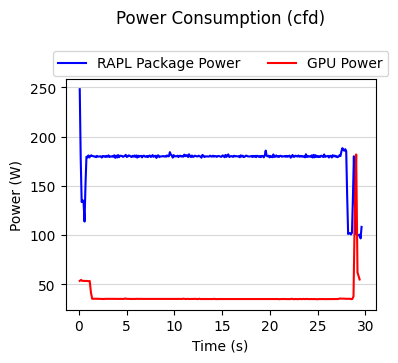

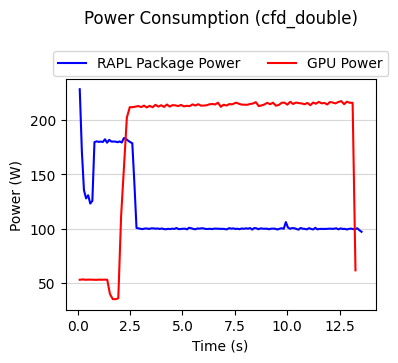

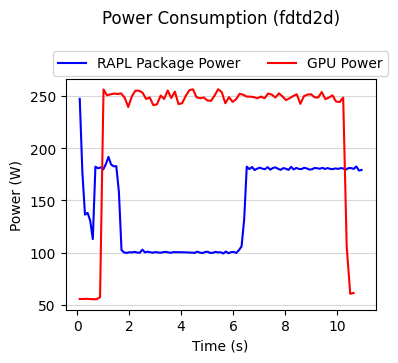

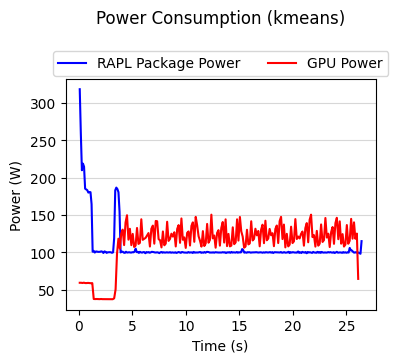

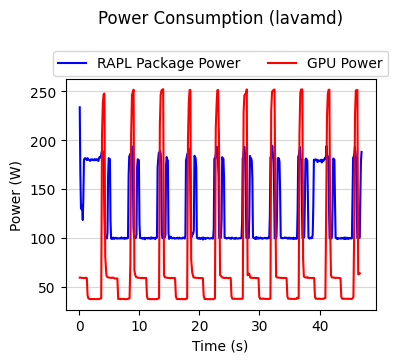

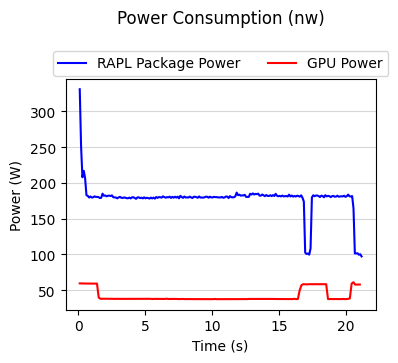

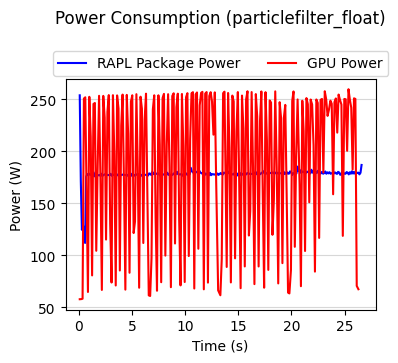

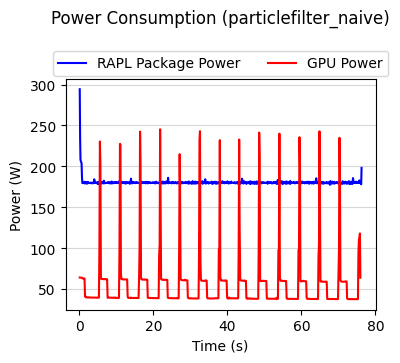

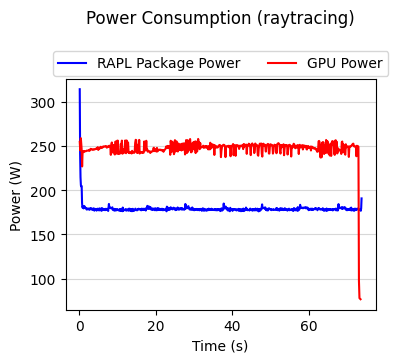

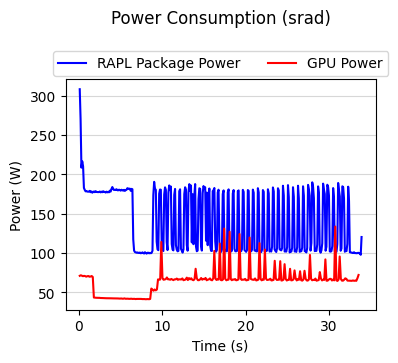

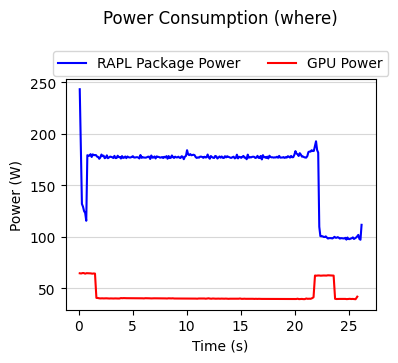

In [12]:
# altis_benchmarks_0
plot_power_CPU_GPU(busspeeddownload_cpu, busspeeddownload_gpu, "busspeeddownload")
plot_power_CPU_GPU(busspeedreadback_cpu, busspeedreadback_gpu, "busspeedreadback")
plot_power_CPU_GPU(maxflops_cpu, maxflops_gpu, "maxflops")

# altis_benchmarks_1
plot_power_CPU_GPU(bfs_cpu, bfs_gpu, "bfs")
plot_power_CPU_GPU(gemm_cpu, gemm_gpu, "gemm")
plot_power_CPU_GPU(gups_cpu, gups_gpu, "gups")
plot_power_CPU_GPU(pathfinder_cpu, pathfinder_gpu, "pathfinder")
plot_power_CPU_GPU(sort_cpu, sort_gpu, "sort")

# altis_benchmarks_2
plot_power_CPU_GPU(cfd_cpu, cfd_gpu, "cfd")
plot_power_CPU_GPU(cfd_double_cpu, cfd_double_gpu, "cfd_double")
# plot_power_CPU_GPU(dwt2d_cpu, dwt2d_gpu, "dwt2d")
plot_power_CPU_GPU(fdtd2d_cpu, fdtd2d_gpu, "fdtd2d")
plot_power_CPU_GPU(kmeans_cpu, kmeans_gpu, "kmeans")
plot_power_CPU_GPU(lavamd_cpu, lavamd_gpu, "lavamd")
# plot_power_CPU_GPU(mandelbrot_cpu, mandelbrot_gpu, "mandelbrot")
plot_power_CPU_GPU(nw_cpu, nw_gpu, "nw")
plot_power_CPU_GPU(particlefilter_float_cpu, particlefilter_float_gpu, "particlefilter_float")
plot_power_CPU_GPU(particlefilter_naive_cpu, particlefilter_naive_gpu, "particlefilter_naive")
plot_power_CPU_GPU(raytracing_cpu, raytracing_gpu, "raytracing")
plot_power_CPU_GPU(srad_cpu, srad_gpu, "srad")
plot_power_CPU_GPU(where_cpu, where_gpu, "where")

### Max Uncore

In [ ]:
data_dir = "./altis_power_res/no_power_shift/max_uncore/"

# altis_benchmarks_1
bfs_cpu = data_dir + "bfs_power_cpu.csv"
bfs_gpu = data_dir + "bfs_power_gpu.csv"
plot_power_CPU_GPU(bfs_cpu, bfs_gpu, "bfs")

data_dir = "./altis_power_res/min_uncore/"

# altis_benchmarks_1
bfs_cpu = data_dir + "bfs_power_cpu.csv"
bfs_gpu = data_dir + "bfs_power_gpu.csv"

plot_power_CPU_GPU(bfs_cpu, bfs_gpu, "bfs")

In [ ]:
# altis_benchmarks_1
lavamd_cpu = data_dir + "lavamd_power_cpu.csv"
lavamd_gpu = data_dir + "lavamd_power_gpu.csv"
plot_power_CPU_GPU(lavamd_cpu, lavamd_gpu, "lavamd")
calculate_energy(lavamd_cpu,lavamd_gpu)

### Min Uncore

In [ ]:
data_dir = "./altis_power_res/no_power_shift/min_uncore/"

# altis_benchmarks_1
lavamd_cpu = data_dir + "lavamd_power_cpu.csv"
lavamd_gpu = data_dir + "lavamd_power_gpu.csv"
plot_power_CPU_GPU(lavamd_cpu, lavamd_gpu, "lavamd")
calculate_energy(lavamd_cpu,lavamd_gpu)

data_dir = "./altis_power_res/"

# altis_benchmarks_1
lavamd_cpu = data_dir + "lavamd_power_cpu.csv"
lavamd_gpu = data_dir + "lavamd_power_gpu.csv"
plot_power_CPU_GPU(lavamd_cpu, lavamd_gpu, "lavamd")
calculate_energy(lavamd_cpu,lavamd_gpu)

### Comparison

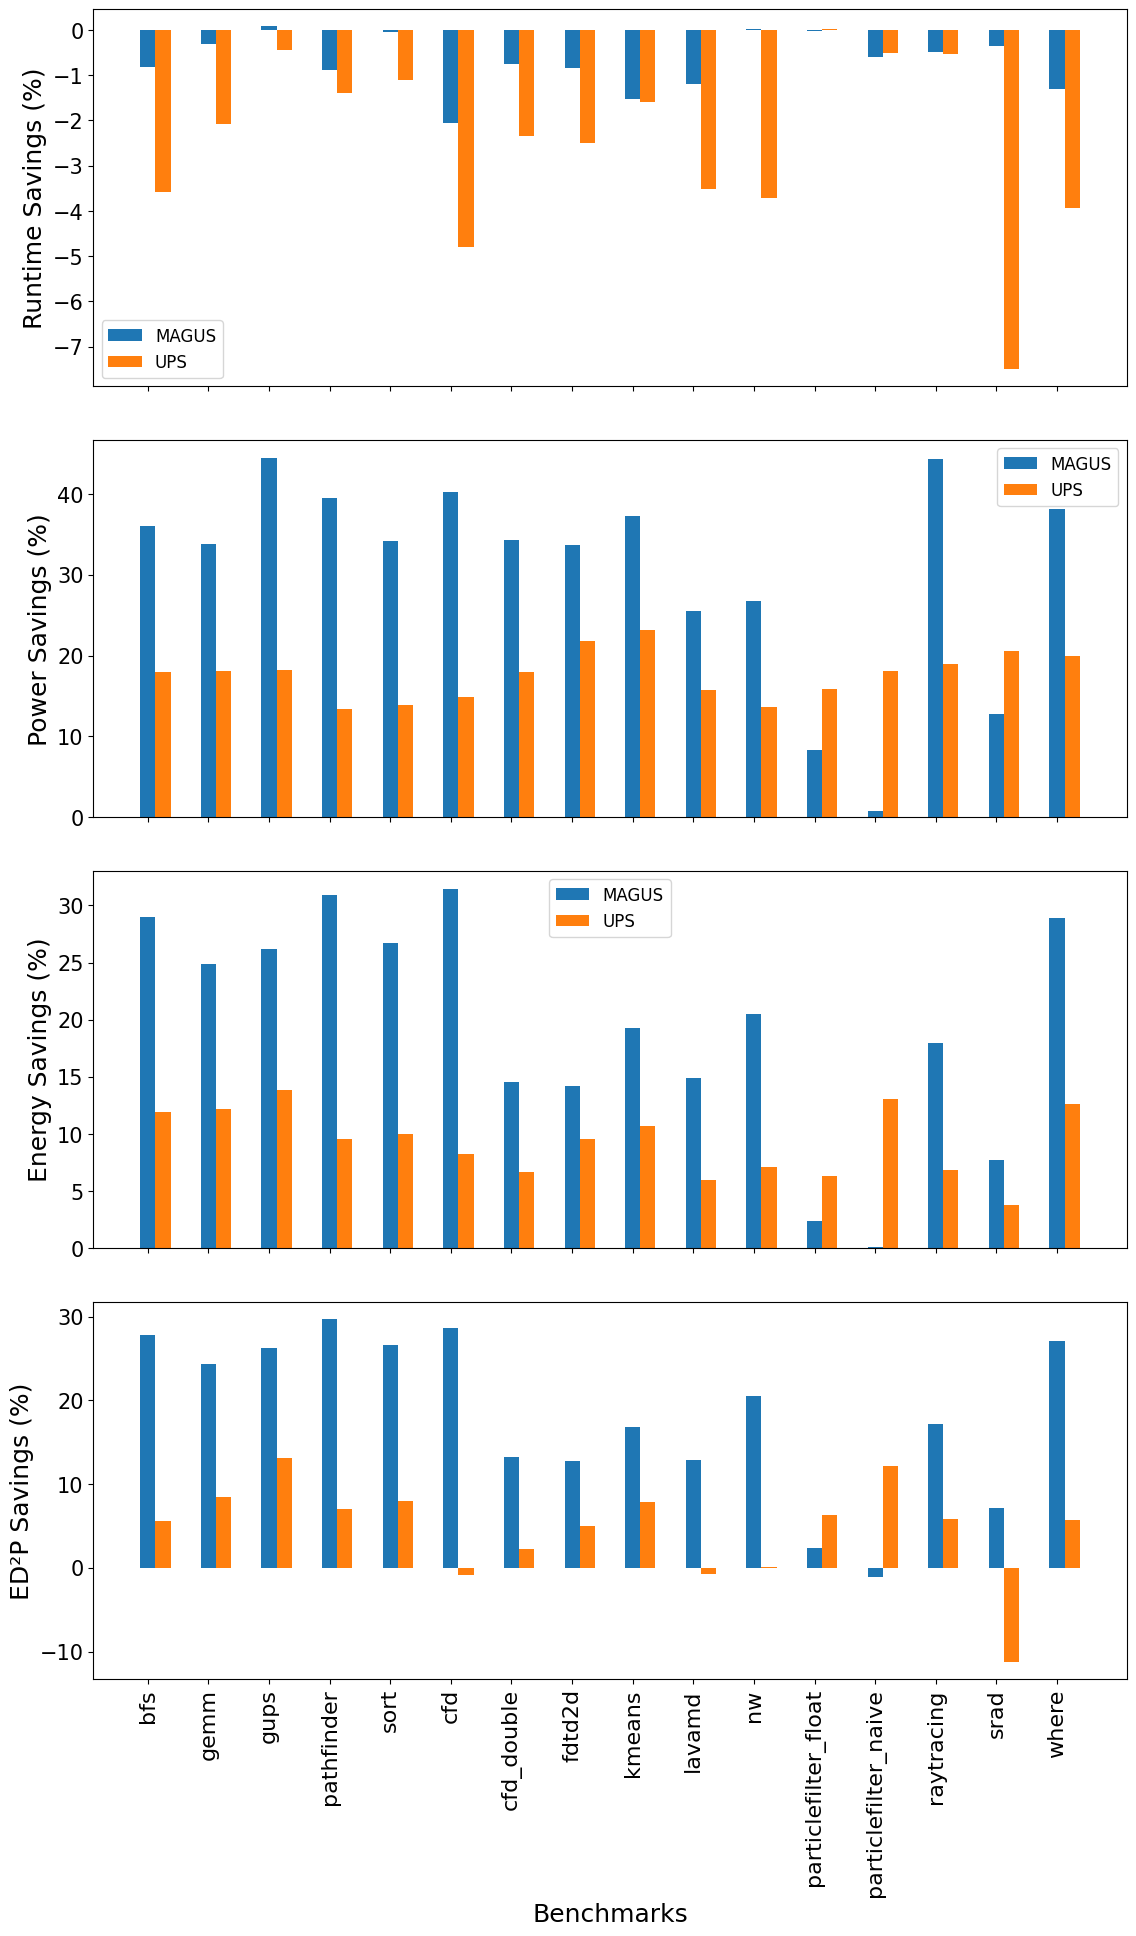

In [11]:
# List of benchmarks
benchmarks = [
     "bfs", "gemm", "gups", 
    "pathfinder", "sort", "cfd", "cfd_double", "fdtd2d", "kmeans", "lavamd", 
    "nw", "particlefilter_float", "particlefilter_naive", "raytracing", "srad", "where"
]

# Directories
baseline_dir = "./altis_power_res/no_power_shift/max_uncore/"
min_uncore_dir = "./altis_power_res/no_power_shift/min_uncore/"
dynamic_uncore_dir = "./altis_power_res/no_power_shift/dynamic_uncore/"
ups_uncore_dir = "./altis_power_res/no_power_shift/ups_uncore/old/"


runtimes_savings, energy_savings, edp_savings, power_savings = calculate_savings_percentage(benchmarks, 
                                                baseline_dir, min_uncore_dir, dynamic_uncore_dir, ups_uncore_dir)
# Plot combined runtime and energy savings
plot_combined_bars_savings(runtimes_savings, energy_savings, edp_savings, power_savings, benchmarks, ['Min Uncore Freq', 'MAGUS', 'UPS'],"ALTIS_saving")

## Memory Pattern

In [11]:
benchmarks = [
    "busspeeddownload", "busspeedreadback", "maxflops", "bfs", "gemm", "gups", 
    "pathfinder", "sort", "cfd", "cfd_double", "fdtd2d", "kmeans", "lavamd", 
    "nw", "particlefilter_float", "particlefilter_naive", "raytracing", "srad", "where"
]
mem_tps_dir_max = "./altis_power_res/no_power_shift/mem_throughput/max_uncore/"
mem_tps_dir_min = "./altis_power_res/no_power_shift/mem_throughput/min_uncore/"
mem_tps_dir_dynamic = "./altis_power_res/no_power_shift/mem_throughput/dynamic_uncore/"
mem_tps_dir_ups = "./altis_power_res/no_power_shift/mem_throughput/ups_uncore/"

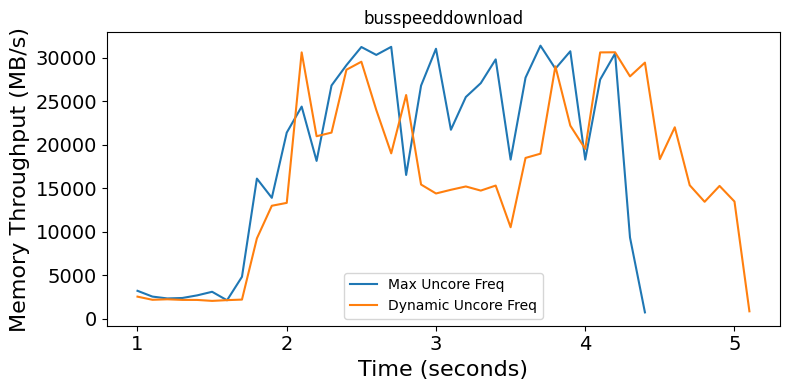

In [22]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,'busspeeddownload')

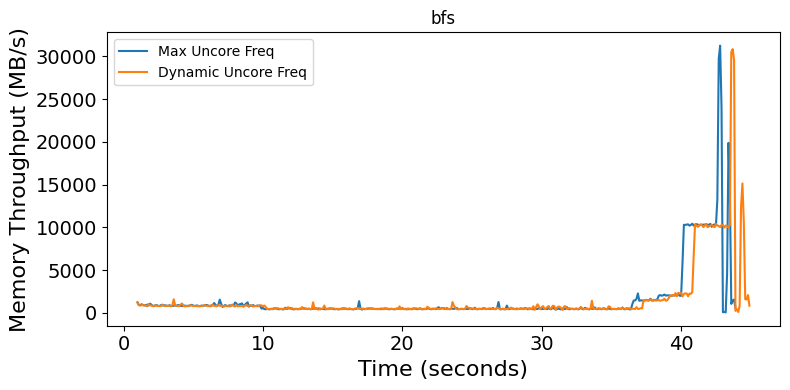

In [23]:
# initial uf should be set at min, since initial mem_throughout is low
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,'bfs')

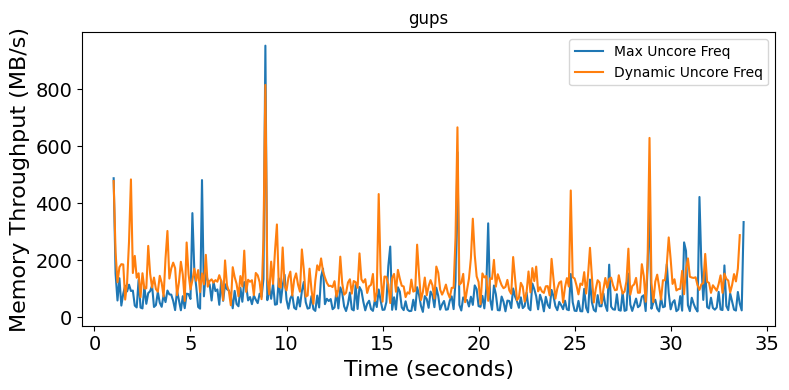

In [24]:
# initial uf should be set at min, since initial mem_throughout is low
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,'gups')

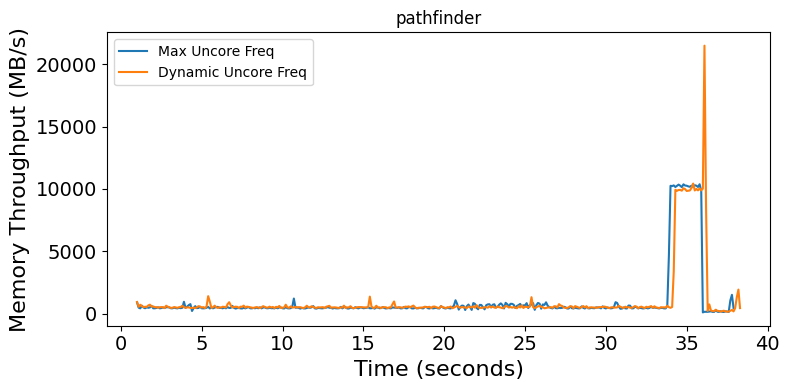

In [25]:
# initial uf should be set at min, since initial mem_throughout is low
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,'pathfinder')

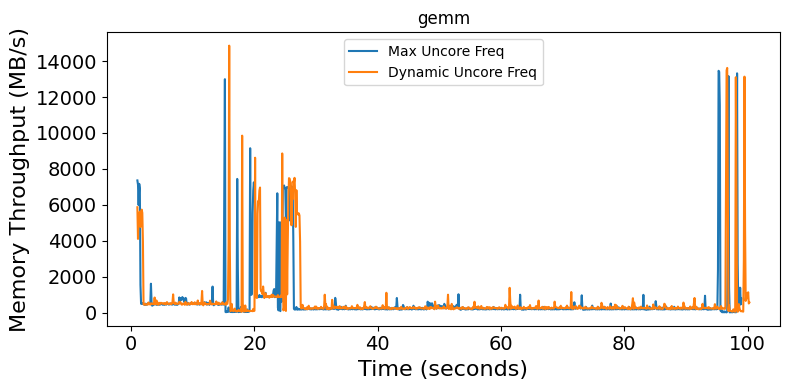

In [26]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,'gemm')

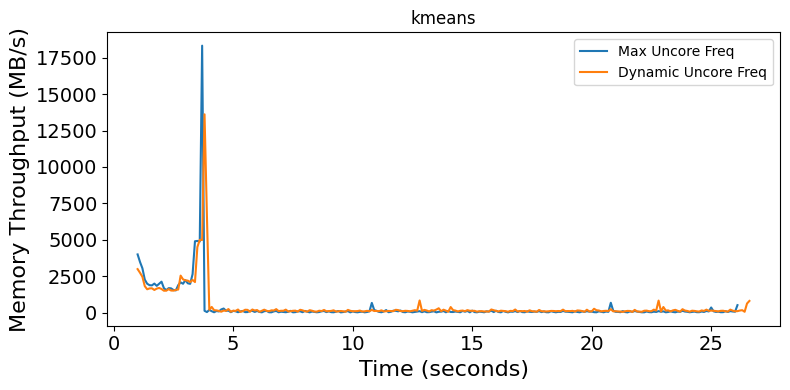

In [27]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,'kmeans')

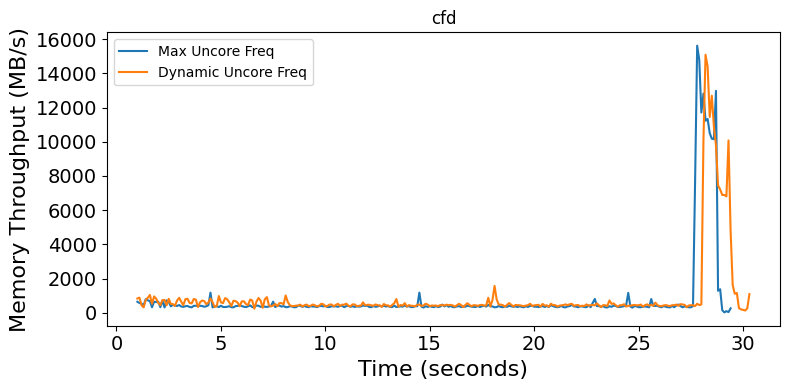

In [28]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,'cfd')

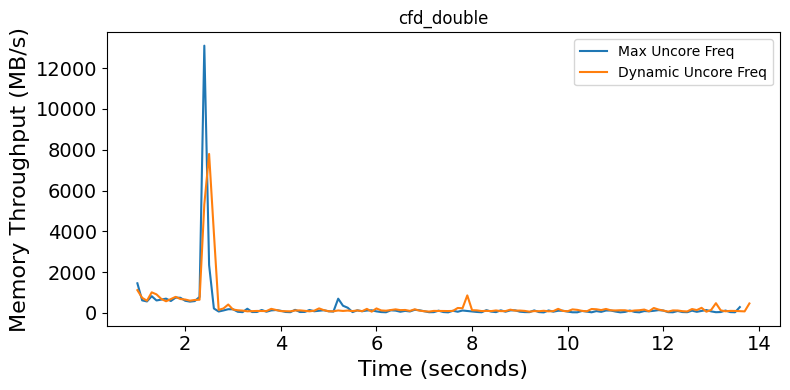

In [29]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,'cfd_double')

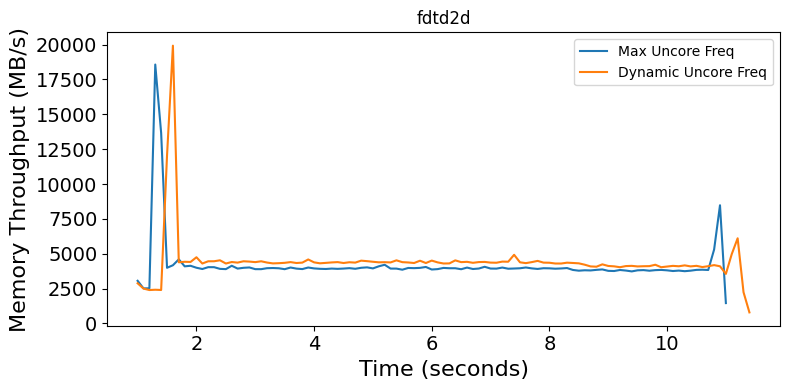

In [30]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,'fdtd2d')

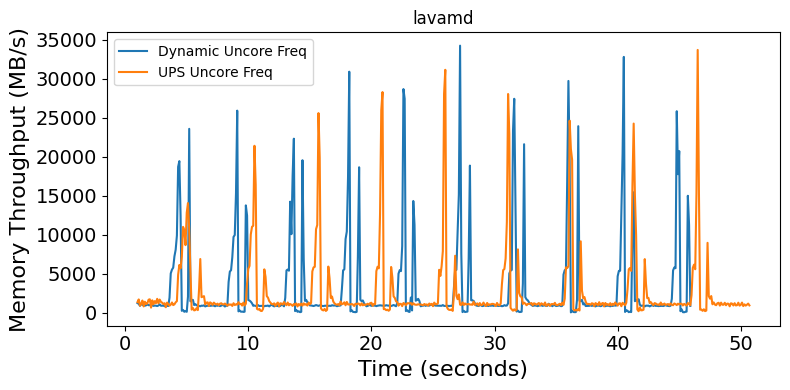

In [16]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,mem_tps_dir_ups,'lavamd')

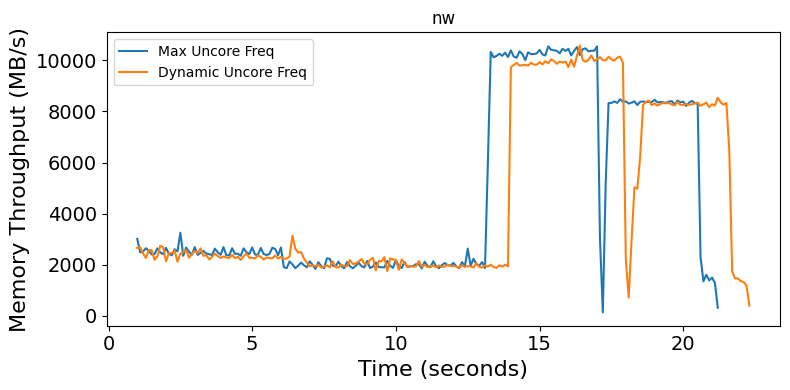

In [32]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,'nw')

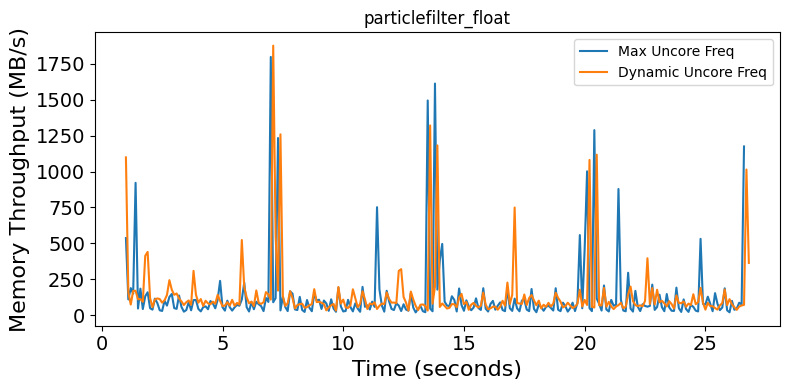

In [33]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,"particlefilter_float")

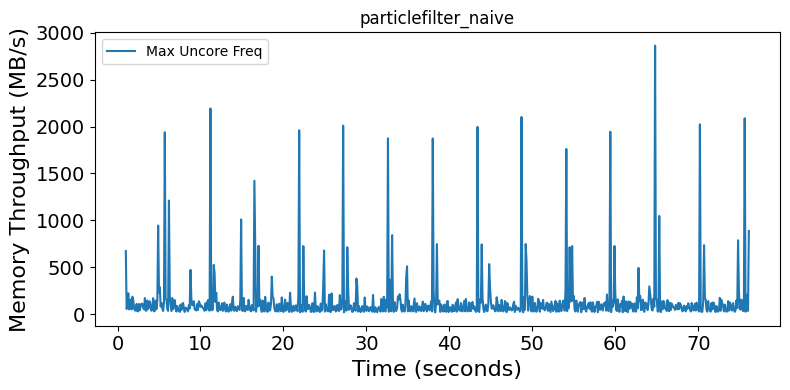

In [11]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,"particlefilter_naive")

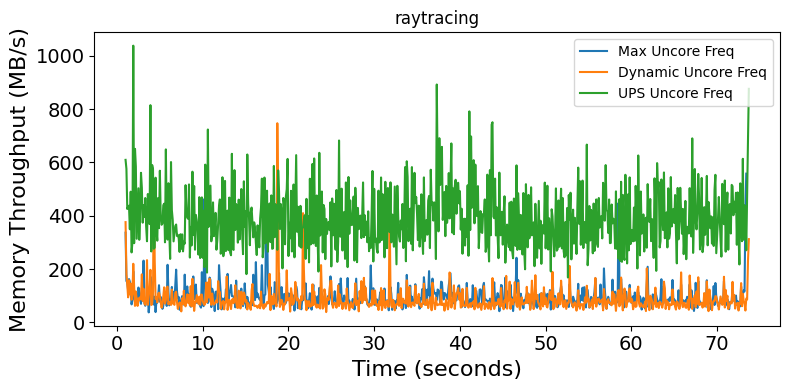

In [12]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic, mem_tps_dir_ups,"raytracing")

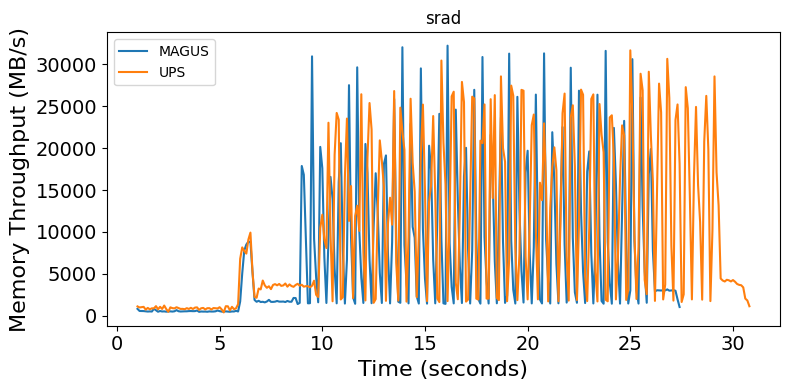

In [19]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic, mem_tps_dir_ups, "srad")

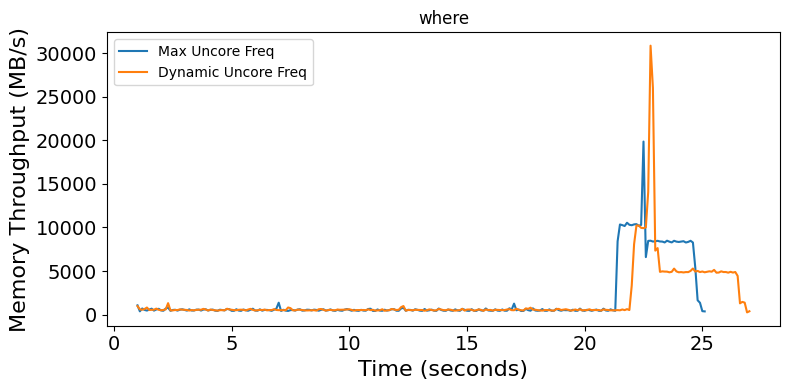

In [37]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,"where")

# ECP

## Comparsion

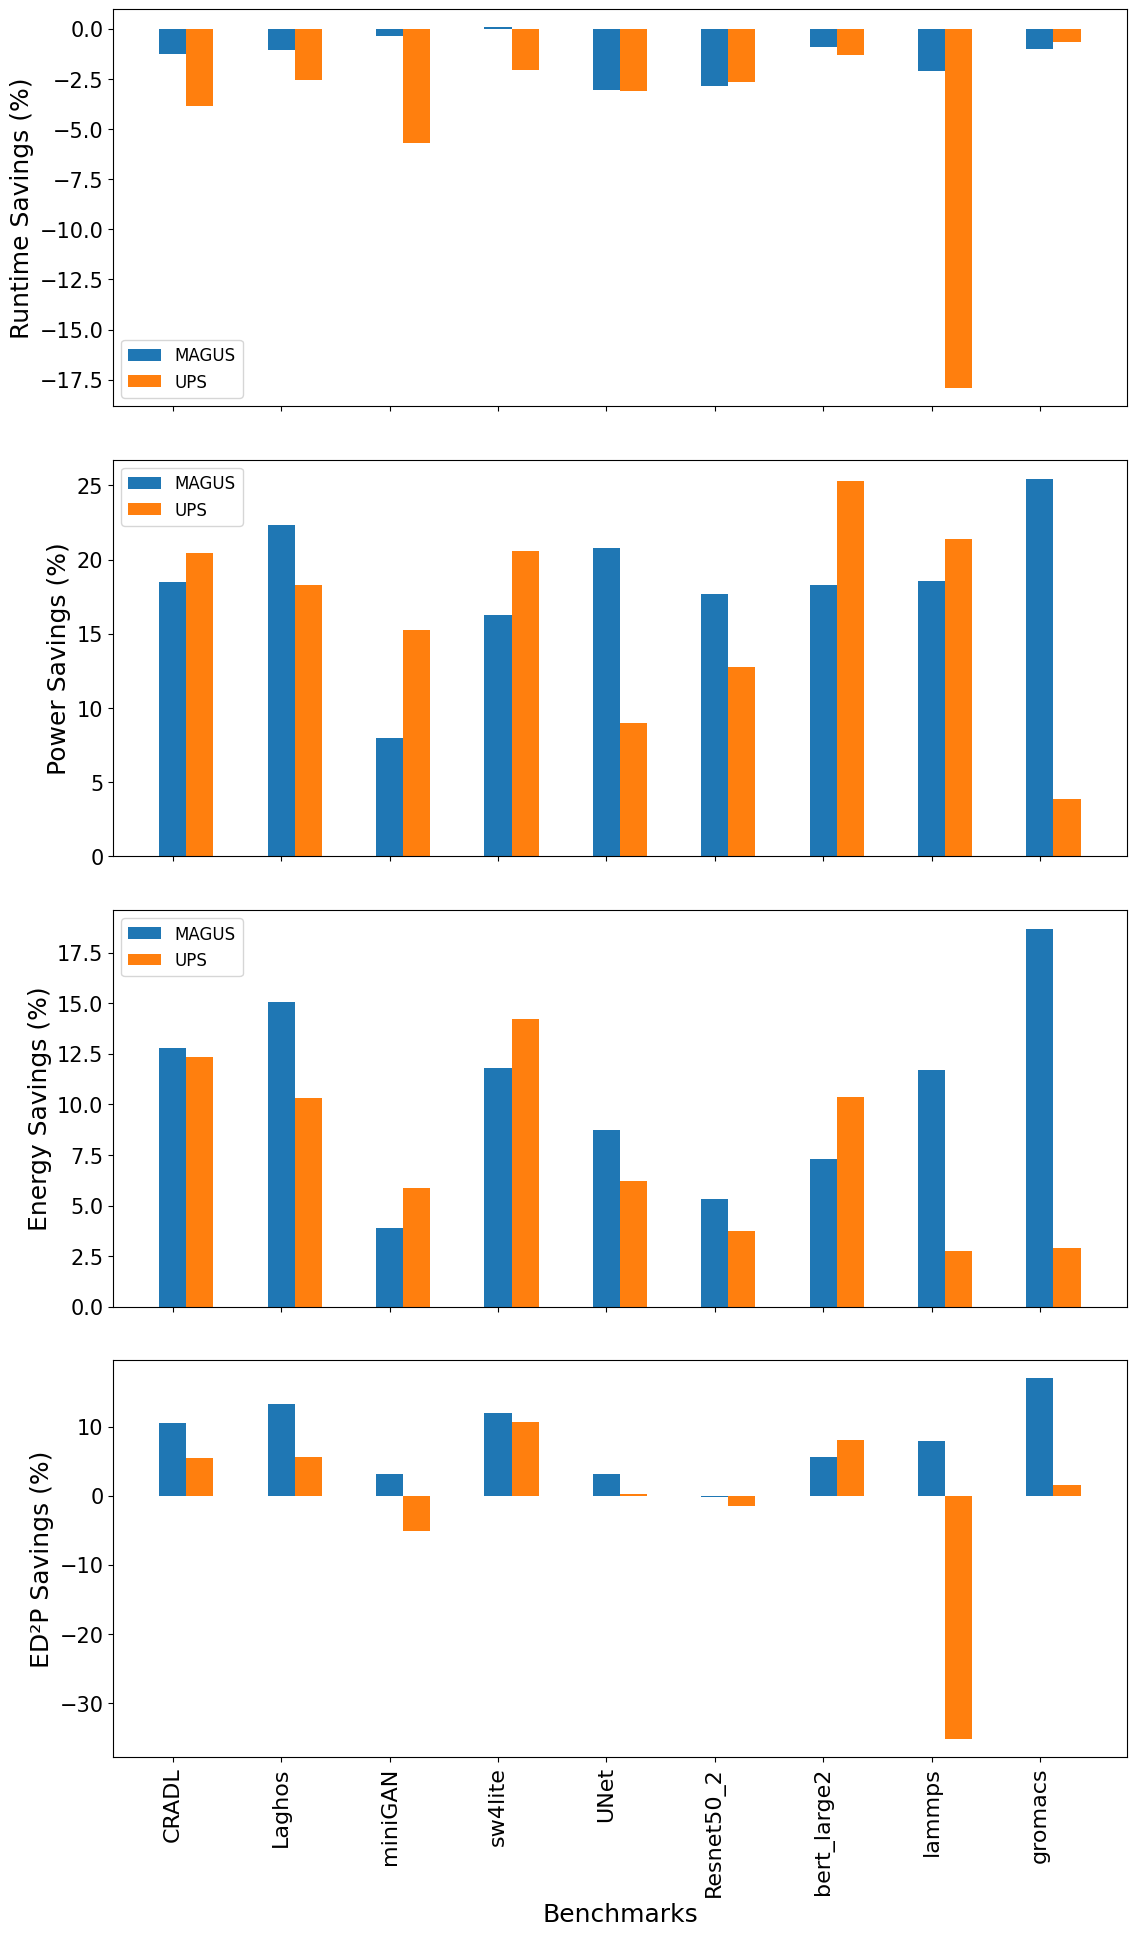

In [12]:
benchmarks = ['CRADL', 'Laghos', 'miniGAN', 'sw4lite','UNet','Resnet50_2','bert_large2','lammps','gromacs']

# Directories
baseline_dir = "./ecp_power_res/no_power_shift/max_uncore/"
min_uncore_dir = "./ecp_power_res/no_power_shift/min_uncore/"
dynamic_uncore_dir = "./ecp_power_res/no_power_shift/dynamic_uncore/"
ups_uncore_dir = "./ecp_power_res/no_power_shift/ups_uncore/old/"

runtimes_savings, energy_savings, edp_savings, power_savings = calculate_savings_percentage(benchmarks, 
                                                baseline_dir, min_uncore_dir, dynamic_uncore_dir,ups_uncore_dir)
# Plot combined runtime and energy savings
plot_combined_bars_savings(runtimes_savings, energy_savings, edp_savings, power_savings, benchmarks, ['Min Uncore Freq', 'MAGUS','UPS'],"ECP_saving")

### Number calculation

In [4]:
energy_savings

{'min': [20.943096577740047,
  28.33562994943426,
  20.246584950973613,
  36.25687260336144,
  19.63021288501806,
  16.683344023747487,
  19.686095901971054],
 'dynamic': [13.611619168693764,
  16.68666882904384,
  7.989426584125618,
  35.70354151486615,
  7.548161628803437,
  6.673414767035422,
  10.927335079839686]}

In [3]:
energy_savings

{'min': [20.943096577740047,
  28.33562994943426,
  20.246584950973613,
  36.25687260336144,
  19.63021288501806,
  16.683344023747487,
  19.26954106986433],
 'dynamic': [13.611619168693764,
  16.68666882904384,
  7.989426584125618,
  35.70354151486615,
  7.548161628803437,
  6.673414767035422,
  10.594877509451038]}

In [3]:
runtimes_savings, energy_savings = calculate_savings_num(benchmarks, 
                                                baseline_dir, min_uncore_dir, dynamic_uncore_dir )

In [4]:
energy_savings

{'min': [2477.135481162166,
  2688.6852785916453,
  1801.409181417359,
  4089.5907445231633,
  3866.831813714636,
  5259.761336400115,
  15578.558661375006],
 'dynamic': [1609.9732278690972,
  1583.3493347226613,
  710.8471101548275,
  4027.177813244655,
  1486.864747330037,
  2103.9288600325854,
  8647.32811429305]}

In [33]:
runtimes_savings

{'min': [np.float64(-14.234475374221802),
  np.float64(-4.6806509494781565),
  np.float64(-3.07357048988343),
  np.float64(-0.8257973194122314),
  np.float64(-5.484189987182617),
  np.float64(-4.305185079574585),
  np.float64(-2.985585689544706)],
 'dynamic': [np.float64(-3.4298219680786133),
  np.float64(-0.3998832702636719),
  np.float64(-0.9530508518219065),
  np.float64(-0.11477017402649636),
  np.float64(-0.19034838676452637),
  np.float64(-0.931220531463623),
  np.float64(-1.739909410476713)]}

In [37]:
## for 100 epoch: bert
# This amount of energy could power an average U.S. 
# household for about 6 months (assuming average usage of 900-1,000 kWh per month).
(8647* (194052/6000) * 811) / 1000000 * 100, mega J

22680.529321399998

In [36]:
((1.7 * (194052/6000) * 811)  * 100) / 60 / 60 / 16, hours

77.41304756944444

In [5]:
#resnet50
(5259 * (128/6.4)) / 1000000 * 100 

10.517999999999999

In [8]:
0.9 * (128/6.4) * 100 / 60, minutes

30.0

## Memory Pattern

In [3]:
mem_tps_dir_max = "./ecp_power_res/no_power_shift/mem_throughput/max_uncore/"
mem_tps_dir_min = "./ecp_power_res/no_power_shift/mem_throughput/min_uncore/"
mem_tps_dir_dynamic = "./ecp_power_res/no_power_shift/mem_throughput/dynamic_uncore/"
mem_tps_dir_ups = "./ecp_power_res/no_power_shift/mem_throughput/ups_uncore/"
benchmarks = ['CRADL', 'Laghos', 'miniGAN', 'sw4lite', 'XSBench', 'UNet', 'Resnet50','bert_large']

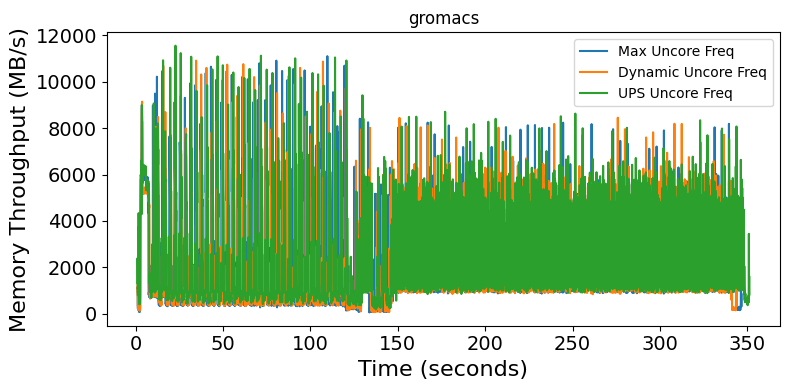

In [40]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,mem_tps_dir_ups,'gromacs')

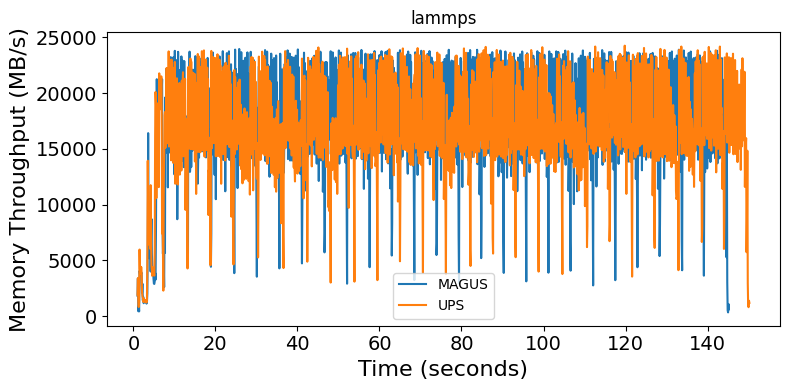

In [23]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,mem_tps_dir_ups,'lammps')

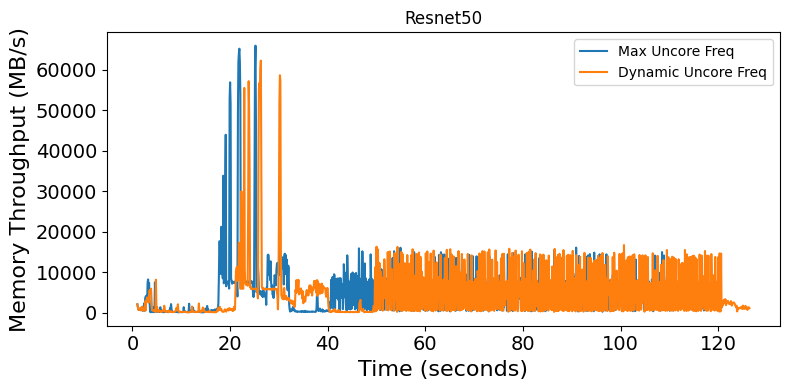

In [39]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,mem_tps_dir_ups,'Resnet50')

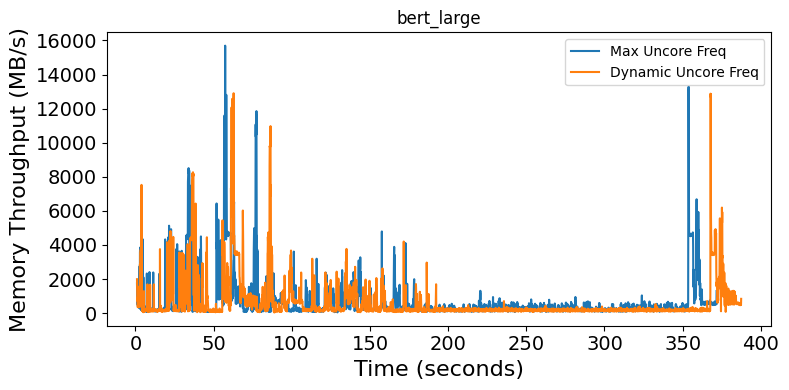

In [40]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,mem_tps_dir_ups,'bert_large')

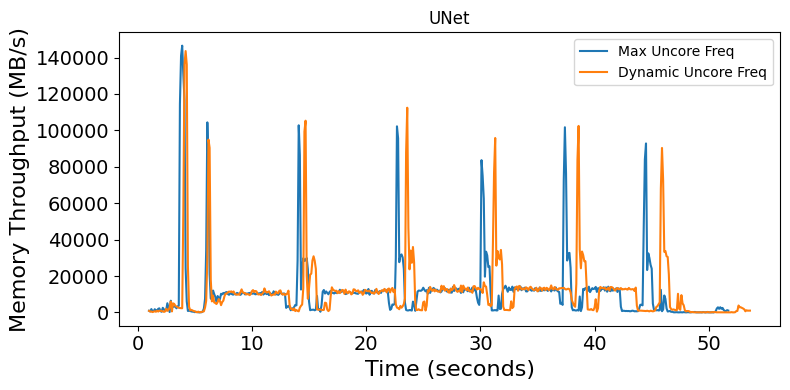

In [42]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,mem_tps_dir_ups,'UNet')

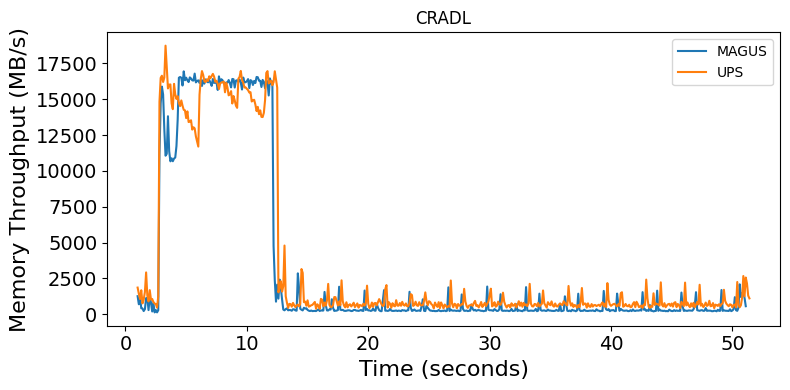

In [25]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,mem_tps_dir_ups,'CRADL')

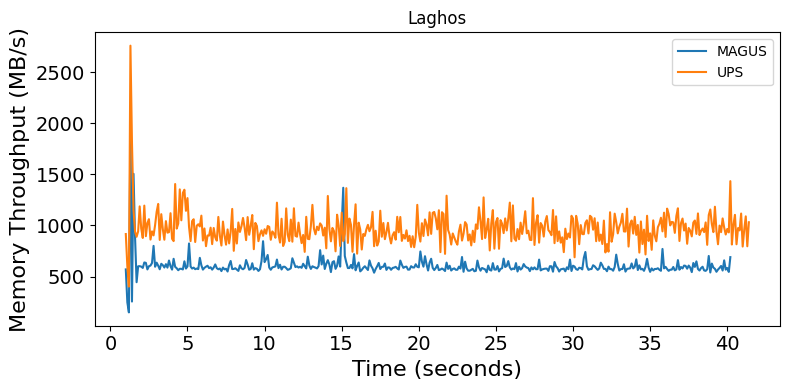

In [26]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,mem_tps_dir_ups,"Laghos")

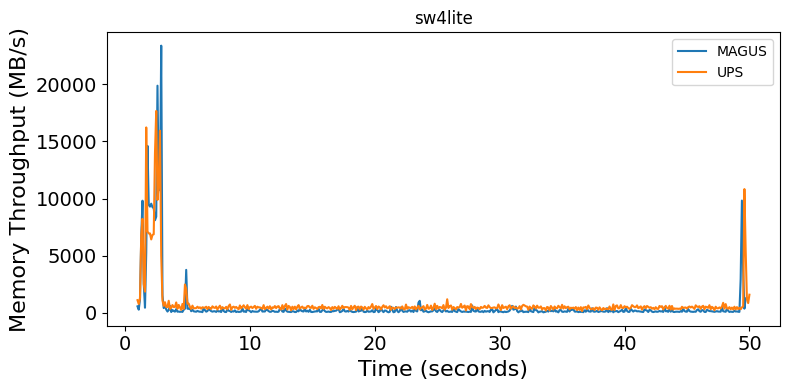

In [27]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,mem_tps_dir_ups,'sw4lite')

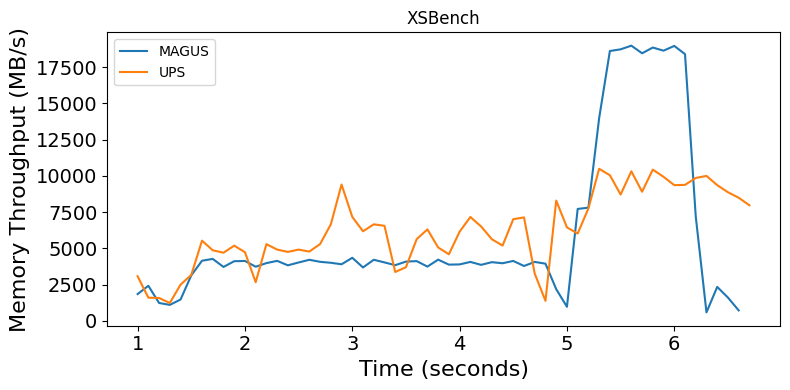

In [28]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,mem_tps_dir_ups,'XSBench')

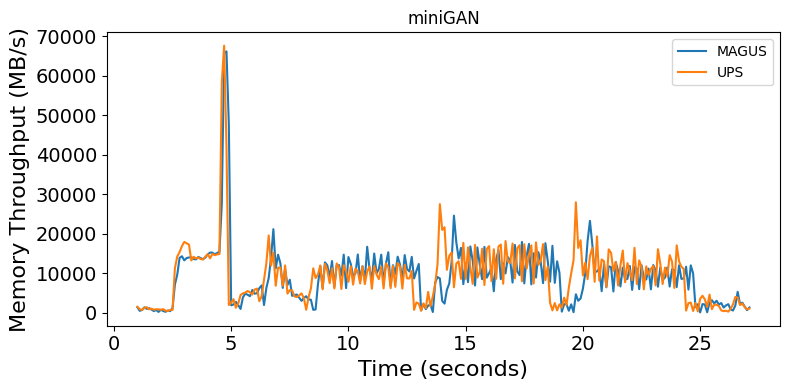

In [29]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,mem_tps_dir_ups,'miniGAN')

# Multi-GPU ECP

## Memory  Pattern

In [4]:
mem_tps_dir_max = "./ecp_power_res/no_power_shift/multiGPU/mem_throughput/max_uncore/"
mem_tps_dir_min = "./ecp_power_res/no_power_shift/multiGPU/mem_throughput/min_uncore/"
mem_tps_dir_dynamic = "./ecp_power_res/no_power_shift/multiGPU/mem_throughput/dynamic_uncore/"
mem_tps_dir_ups = "./ecp_power_res/no_power_shift/multiGPU/mem_throughput/ups_uncore/"

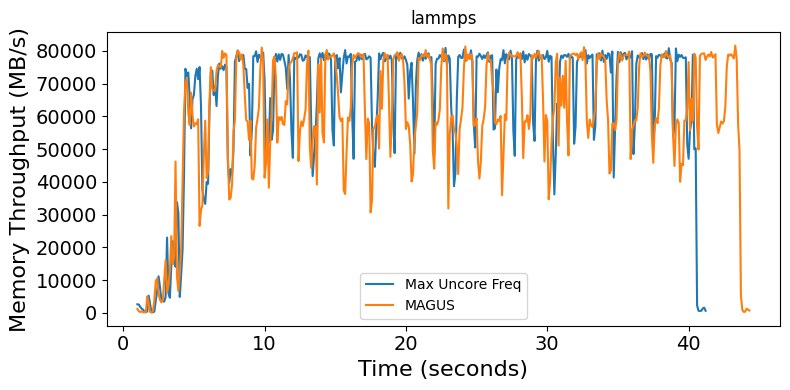

In [16]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,mem_tps_dir_ups,'lammps')

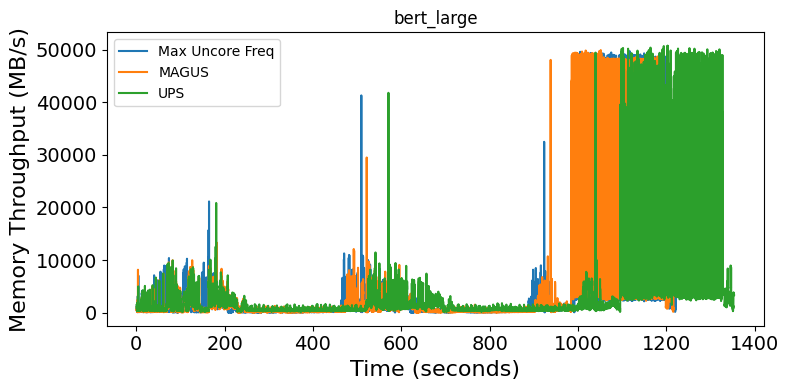

In [7]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,mem_tps_dir_ups,'bert_large')

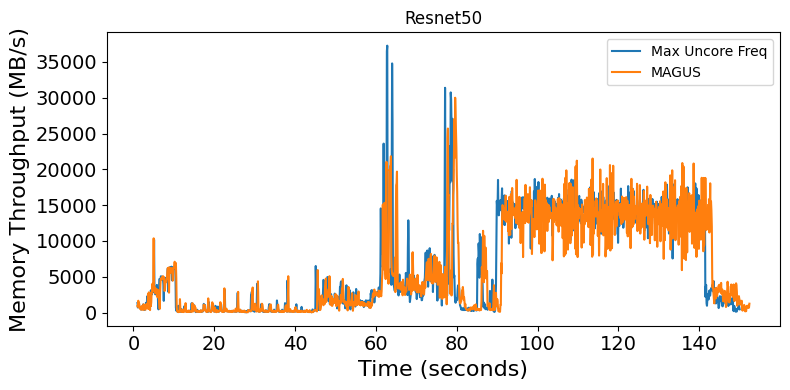

In [14]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,mem_tps_dir_ups,'Resnet50')

## Comparsion

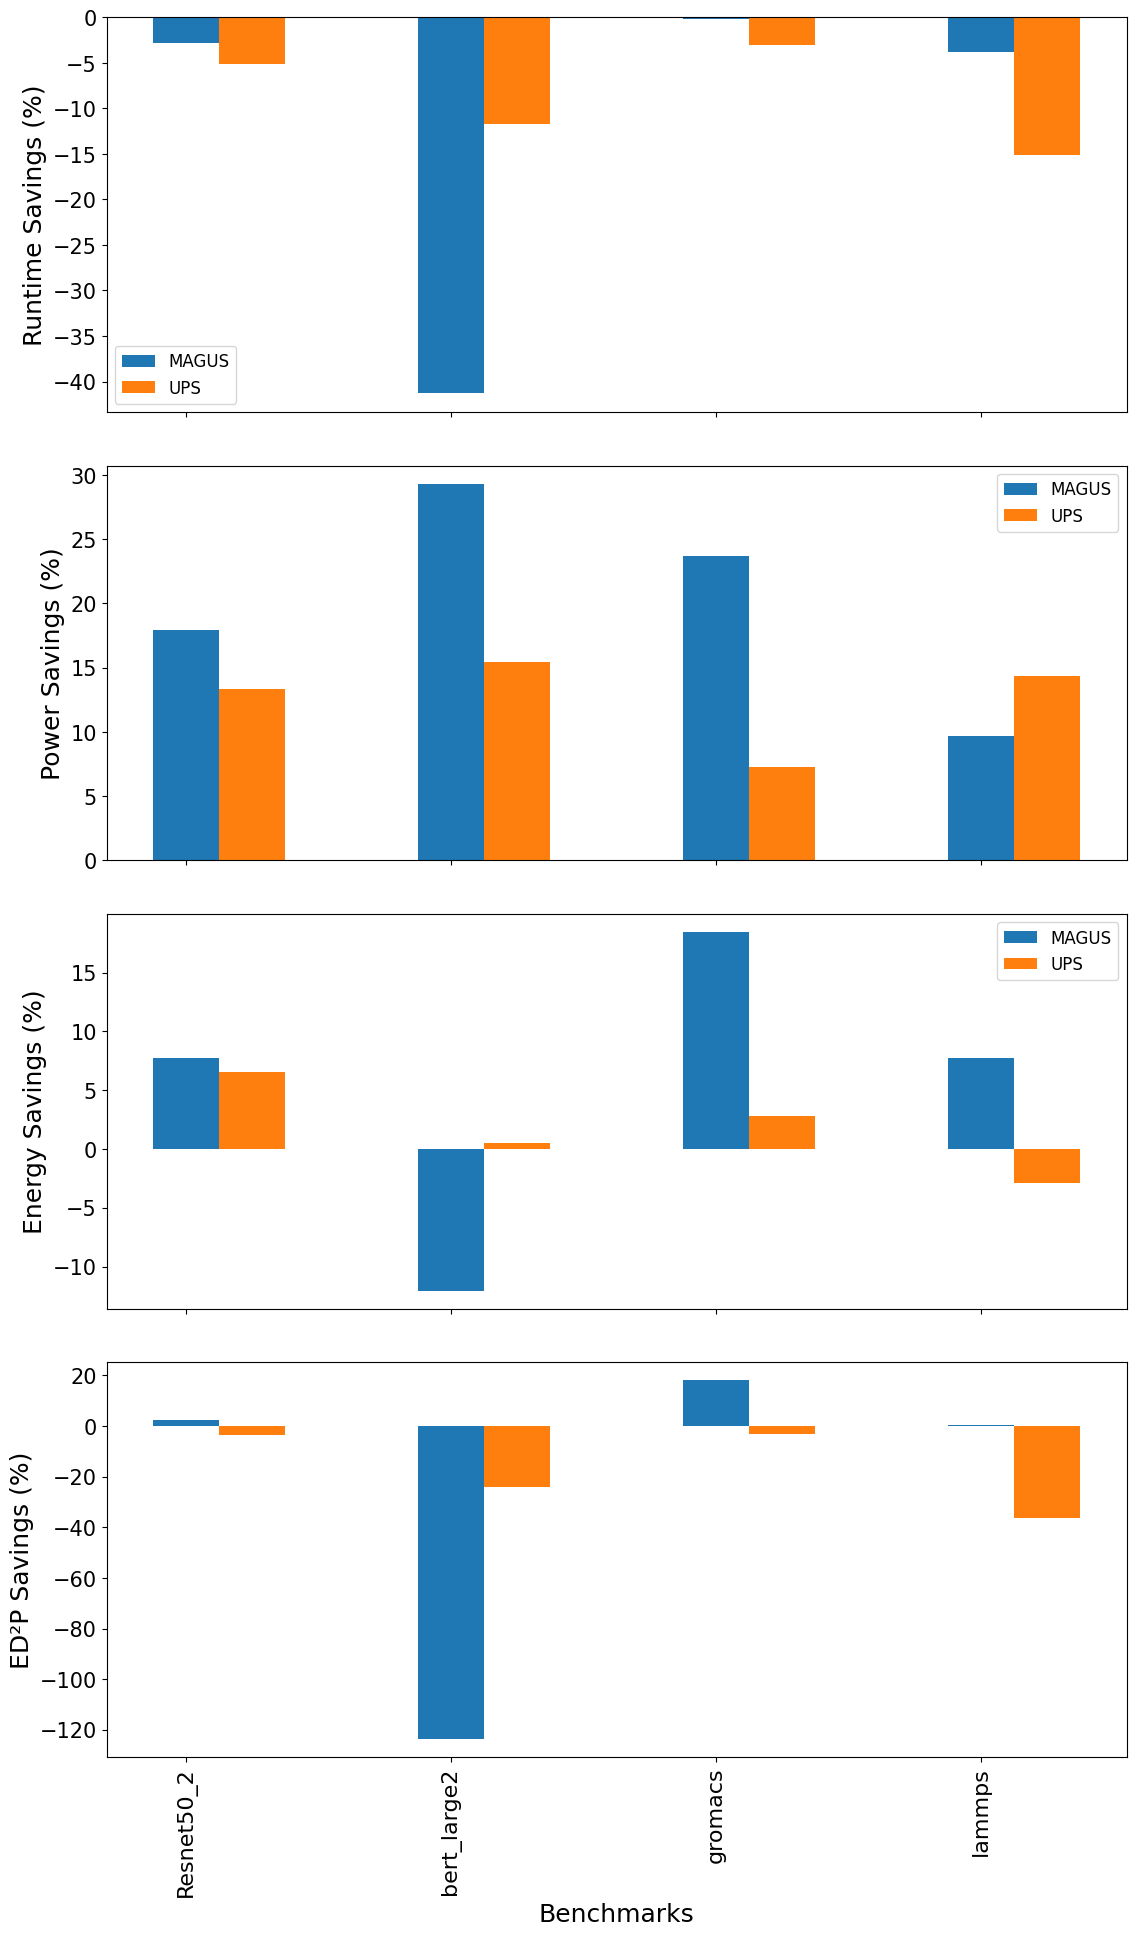

In [3]:
benchmarks = ['Resnet50_2','bert_large2','gromacs','lammps']
baseline_dir = "./ecp_power_res/no_power_shift/multiGPU/max_uncore/"
min_uncore_dir = "./ecp_power_res/no_power_shift/multiGPU/min_uncore/"
dynamic_uncore_dir = "./ecp_power_res/no_power_shift/multiGPU/dynamic_uncore/"
ups_uncore_dir = "./ecp_power_res/no_power_shift/multiGPU/ups_uncore/"

runtimes_savings, energy_savings, edp_savings, power_savings = calculate_savings_percentage(benchmarks, 
                                                baseline_dir, min_uncore_dir, dynamic_uncore_dir,ups_uncore_dir)
# Plot combined runtime and energy savings
plot_combined_bars_savings(runtimes_savings, energy_savings, edp_savings, power_savings, benchmarks, ['Min Uncore Freq', 'MAGUS','UPS'],"ECP_saving")

# NPB

## Memory Pattern

In [3]:
mem_tps_dir_max = "./npb_power_res/no_power_shift/mem_throughput/max_uncore/"
mem_tps_dir_min = "./npb_power_res/no_power_shift/mem_throughput/min_uncore/"
mem_tps_dir_dynamic = "./npb_power_res/no_power_shift/mem_throughput/dynamic_uncore/"
mem_tps_dir_ups = "./npb_power_res/no_power_shift/mem_throughput/ups_uncore/"
benchmarks = ['bt','ep','ft','lu','mg']

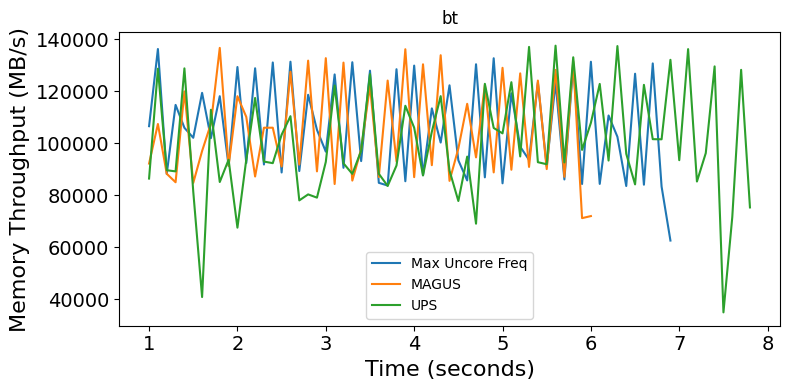

In [16]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,mem_tps_dir_ups,'bt')

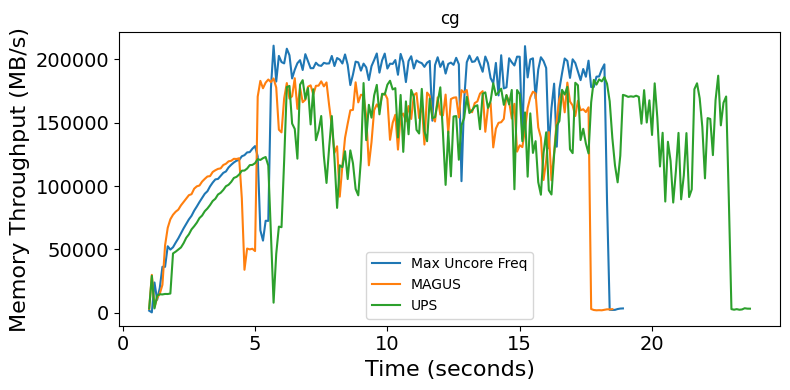

In [4]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,mem_tps_dir_ups,'cg')

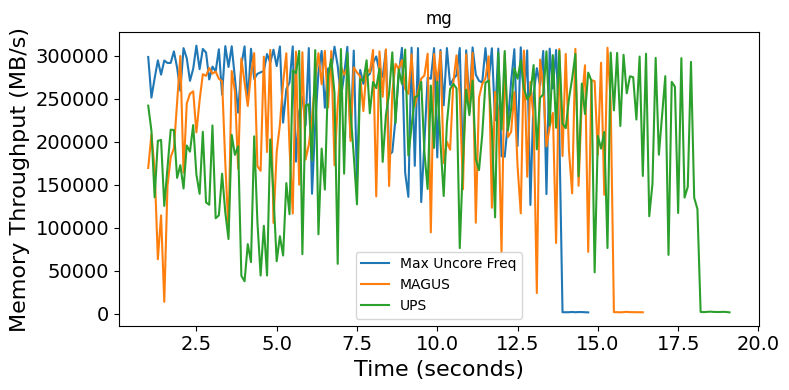

In [7]:
plot_memory_throughput(mem_tps_dir_max,mem_tps_dir_min,mem_tps_dir_dynamic,mem_tps_dir_ups,'mg')

## Comparsion

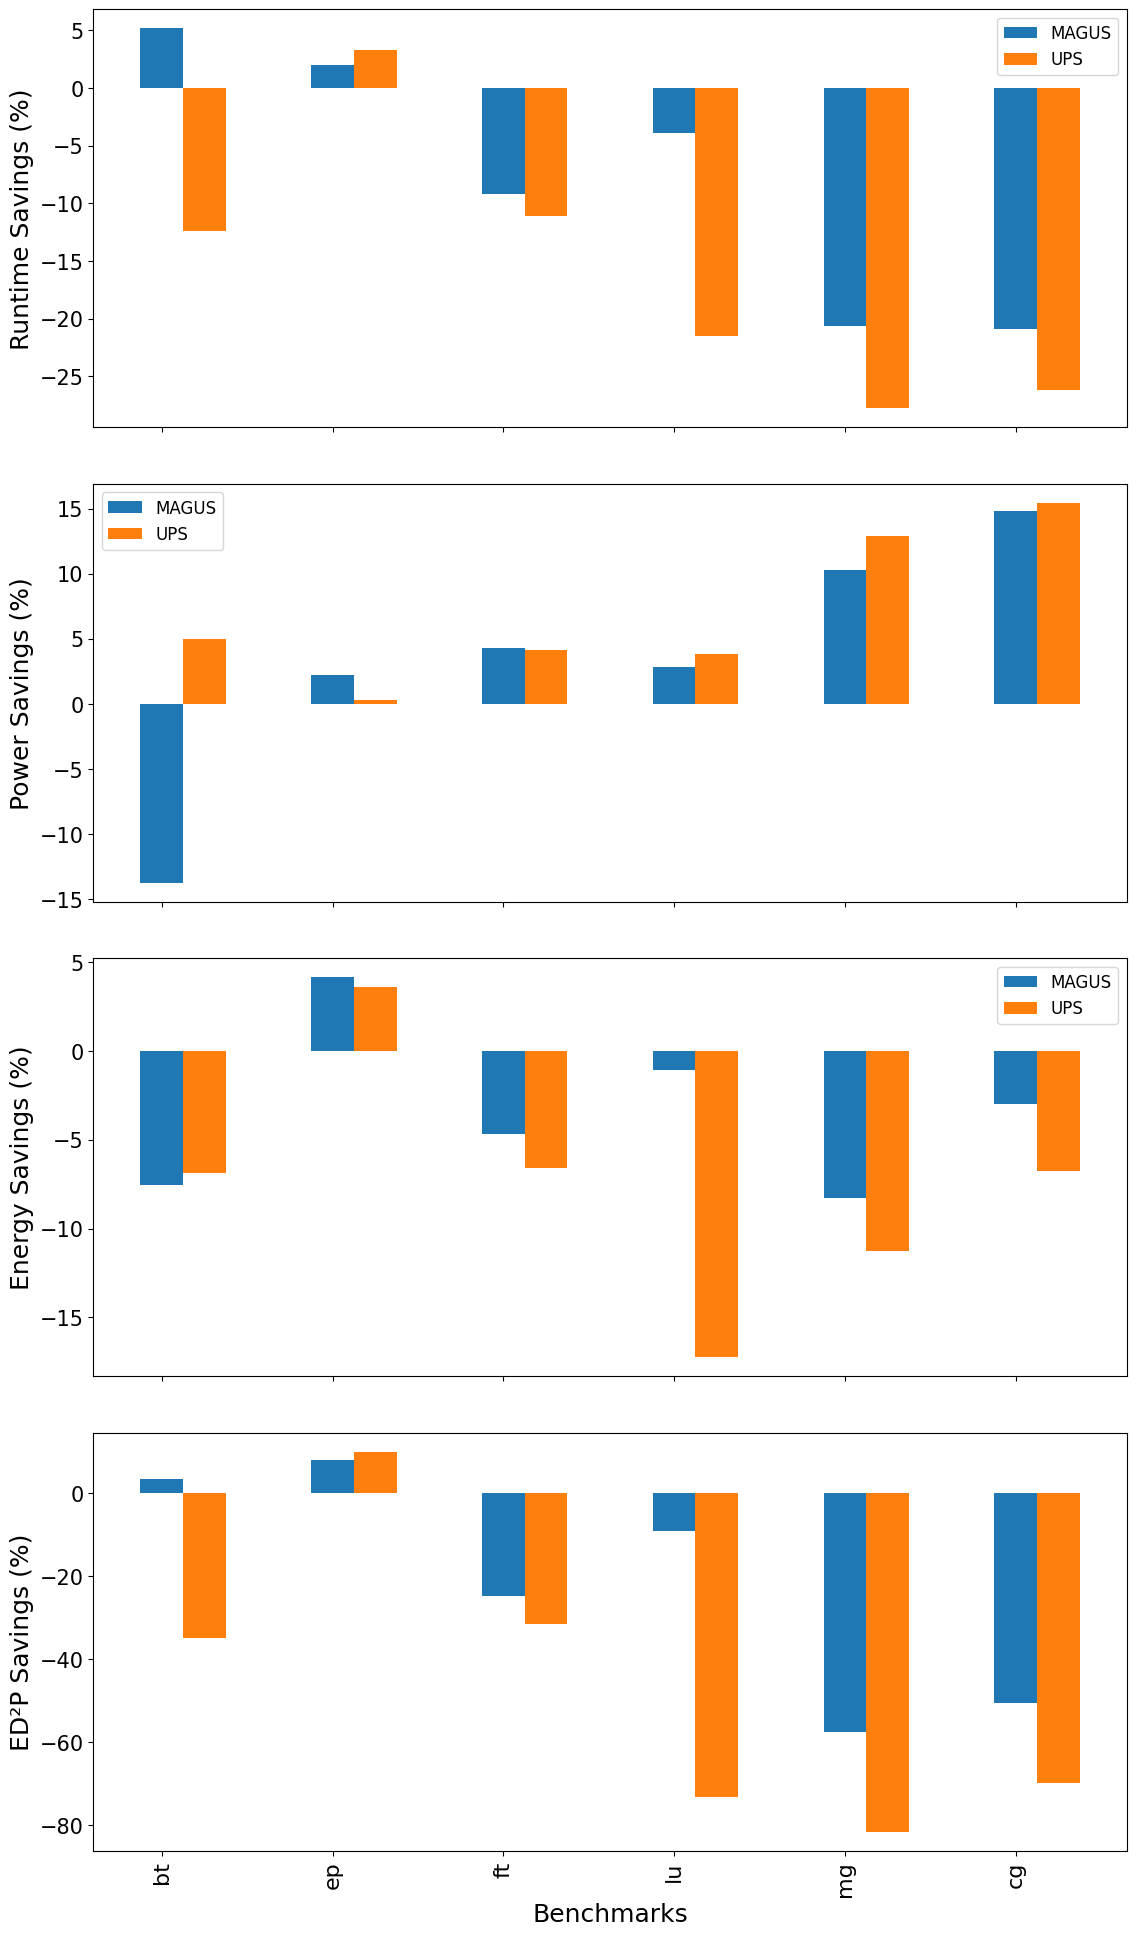

In [6]:
benchmarks = ['bt','ep','ft','lu','mg','cg']
baseline_dir = "./npb_power_res/no_power_shift/max_uncore/"
min_uncore_dir = "./npb_power_res/no_power_shift/min_uncore/"
dynamic_uncore_dir = "./npb_power_res/no_power_shift/dynamic_uncore/"
ups_uncore_dir = "./npb_power_res/no_power_shift/ups_uncore/"

runtimes_savings, energy_savings, edp_savings, power_savings = calculate_savings_percentage_cpu(benchmarks, 
                                                baseline_dir, min_uncore_dir, dynamic_uncore_dir,ups_uncore_dir)
# Plot combined runtime and energy savings
plot_combined_bars_savings(runtimes_savings, energy_savings, edp_savings, power_savings, benchmarks, ['Min Uncore Freq', 'MAGUS','UPS'],"ECP_saving")